In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Authenticated
Mounted at /content/drive


In [ ]:
%%bigquery df --project touhua-001

select distinct description

FROM
touhua-001.dm_sryhma.d_product

KeyboardInterrupt: 

In [ ]:
df

In [ ]:
test = df

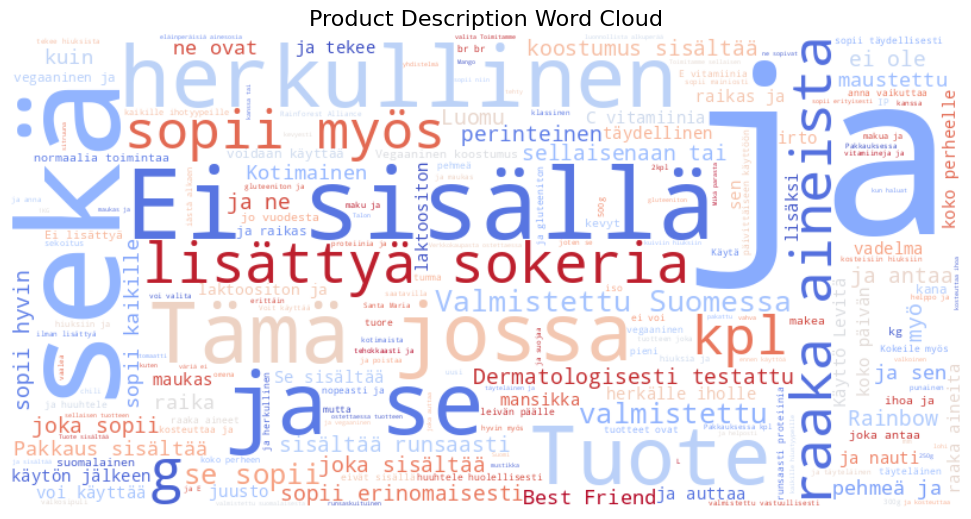

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Filter out None values and concatenate all descriptions into a single string
feedback = " ".join([desc for desc in df['description'].tolist() if desc is not None])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='coolwarm',
                      contour_width=1,
                      contour_color='steelblue').generate(feedback)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Product Description Word Cloud', fontsize=16)
plt.tight_layout(pad=0)
plt.show()

# Supplier luokitelu

In [ ]:
%%bigquery df --project touhua-001

select distinct supplierName
FROM
touhua-001.dm_sryhma.d_product

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:

df['supplierName'] = df['supplierName'].fillna('Unknown Supplier')

In [ ]:
df

,supplierName
0,Inproba B.V.
1,Huhtamaki Foodservice Nordic Oy
2,Kuvalan Maatila ja Liha Tmi
3,Kemppainen Sanni
4,Sanni Kemppainen
...,...
6932,Huahtosen Tila Oy
6933,Pekka Luukkainen
6934,V. Besana spa
6935,MÄKILÄN LEIPOMO


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import re

# 1. Tekstin esikäsittely
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zåäö\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 2. TF-IDF Vektorisointi
def get_tfidf_matrix(texts):
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
    return vectorizer.fit_transform(texts)

# 3. Merkkijonojen samankaltaisuuden mittaaminen
def find_similar_strings(texts, threshold=0.8):
    tfidf_matrix = get_tfidf_matrix(texts)
    similarity_matrix = cosine_similarity(tfidf_matrix)

    similar_pairs = []
    for i in range(len(texts)):
        for j in range(i+1, len(texts)):
            similarity = similarity_matrix[i, j]
            if similarity >= threshold:
                similar_pairs.append((texts[i], texts[j], similarity * 100))

    return similar_pairs

# 4. Klusterointi
def cluster_strings(texts, eps=eps, min_samples=2):
    tfidf_matrix = get_tfidf_matrix(texts)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
    clusters = dbscan.fit_predict(tfidf_matrix)
    return clusters

# Päivitetty funktio outlierien käsittelyyn
def handle_outliers(df, similarity_threshold=0.8):
    outliers = df[df['cluster'] == -1]
    non_outliers = df[df['cluster'] != -1]

    if non_outliers.empty:
        print("Varoitus: Kaikki toimittajat ovat outliereja. Tarkista klusterointiparametrit.")
        return df

    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
    tfidf_matrix = vectorizer.fit_transform(df['processed_name'])

    for idx in outliers.index:
        outlier_vector = tfidf_matrix[df.index.get_loc(idx)]
        non_outlier_indices = [df.index.get_loc(i) for i in non_outliers.index]
        similarities = cosine_similarity(outlier_vector, tfidf_matrix[non_outlier_indices])
        most_similar_idx = similarities.argmax()
        if similarities[0, most_similar_idx] >= similarity_threshold:
            df.at[idx, 'cluster'] = non_outliers.iloc[most_similar_idx]['cluster']

    return df


def unify_supplier_names(df, eps, min_samples=2, similarity_threshold=0.8):
    df = df.dropna(subset=['supplierName']).drop_duplicates(subset=['supplierName'])
    df['processed_name'] = df['supplierName'].apply(preprocess_text)
    df = df[df['processed_name'] != ""]

    unique_processed_names = df['processed_name'].unique()
    similar_pairs = find_similar_strings(unique_processed_names, threshold=similarity_threshold)
    clusters = cluster_strings(unique_processed_names, eps=eps, min_samples=min_samples)

    cluster_dict = {name: cluster for name, cluster in zip(unique_processed_names, clusters)}
    df['cluster'] = df['processed_name'].map(cluster_dict)

    # Käsittelee outlierit
    df = handle_outliers(df, similarity_threshold)

    return df, similar_pairs

# Analyysi- ja print
def print_cluster_analysis(df):
    total_suppliers = len(df)
    clustered_suppliers = df[df['cluster'] != -1].shape[0]
    outlier_suppliers = df[df['cluster'] == -1].shape[0]
    unique_clusters = df['cluster'].nunique() - (1 if -1 in df['cluster'].unique() else 0)

    print(f"Kokonaismäärä toimittajia: {total_suppliers}")
    print(f"Toimittajia klustereissa: {clustered_suppliers} ({clustered_suppliers/total_suppliers*100:.2f}%)")
    print(f"Outlier-toimittajia: {outlier_suppliers} ({outlier_suppliers/total_suppliers*100:.2f}%)")
    print(f"Uniikkien klusterien määrä: {unique_clusters}")

def print_similar_pairs(similar_pairs, limit=10):
    print("\nSamankaltaiset parit (top 10):")
    for pair in sorted(similar_pairs, key=lambda x: x[2], reverse=True)[:limit]:
        print(f"Samankaltaiset: {pair[0]} - {pair[1]} (Samankaltaisuus: {pair[2]:.2f}%)")

def print_clusters(df, limit=10):
    print(f"\nEsimerkkejä klustereista (top {limit}):")
    for cluster in sorted(df['cluster'].unique()):
        if cluster != -1:
            cluster_members = df[df['cluster'] == cluster]['supplierName'].tolist()
            print(f"\nKlusteri {cluster} (koko: {len(cluster_members)}):")
            print(cluster_members[:5])  # Tulosta vain 5 ensimmäistä jäsentä
        if limit <= 0:
            break
        limit -= 1

def print_outliers(df, limit=10):
    print(f"\nEsimerkkejä outlier-toimittajista (top {limit}):")
    print(df[df['cluster'] == -1]['supplierName'].head(limit).tolist())


if __name__ == "__main__":

    # Tässä voi muokata herkyysparameteja
    eps = 0.30 # herkyyden säätö
    min_samples = 2
    similarity_threshold = 0.8

    df, similar_pairs = unify_supplier_names(df, eps=eps, min_samples=min_samples, similarity_threshold=similarity_threshold)

    # Tulosta analyysit
    #print_cluster_analysis(df)
    #print_similar_pairs(similar_pairs)
    #print_clusters(df)
    #print_outliers(df)



In [ ]:
df

,supplierName,processed_name,cluster
0,Inproba B.V.,inproba bv,-1
1,Huhtamaki Foodservice Nordic Oy,huhtamaki foodservice nordic oy,0
2,Kuvalan Maatila ja Liha Tmi,kuvalan maatila ja liha tmi,1
3,Kemppainen Sanni,kemppainen sanni,2
4,Sanni Kemppainen,sanni kemppainen,2
...,...,...,...
6932,Huahtosen Tila Oy,huahtosen tila oy,-1
6933,Pekka Luukkainen,pekka luukkainen,-1
6934,V. Besana spa,v besana spa,450
6935,MÄKILÄN LEIPOMO,mäkilän leipomo,124


In [ ]:
import pandas as pd
import numpy as np
import os
import json

# Function to assign unique IDs to outliers
def assign_unique_ids_to_outliers(df):
    # Create a copy of the DataFrame to avoid modifying the original
    df_new = df.copy()

    # Find the maximum cluster ID (excluding -1)
    max_cluster_id = df_new['cluster'].max()

    # If all clusters are -1, start from 0
    if max_cluster_id == -1:
        max_cluster_id = 0

    # Create a mask for outliers
    outlier_mask = df_new['cluster'] == -1

    # Count the number of outliers
    num_outliers = outlier_mask.sum()

    # Create an array of new unique IDs for outliers
    new_ids = np.arange(max_cluster_id + 1, max_cluster_id + 1 + num_outliers)

    # Assign new unique IDs to outliers
    df_new.loc[outlier_mask, 'cluster'] = new_ids

    return df_new

# Function to convert DataFrame to the desired JSON format
def df_to_json(df):
    # Grouping by cluster and getting the processed names under each cluster
    cluster_dict = df.groupby('cluster')['processed_name'].apply(list).to_dict()

    # Convert the dictionary to JSON
    json_output = json.dumps(cluster_dict, indent=4)

    return json_output

# Assuming 'df' is your existing DataFrame with cluster assignments
df_with_unique_ids = assign_unique_ids_to_outliers(df)

# Convert the DataFrame to JSON
json_output = df_to_json(df_with_unique_ids)

# Save the JSON to a file
output_path = '/content/drive/MyDrive/supplierNameID'
os.makedirs(output_path, exist_ok=True)  # Create the directory if it doesn't exist
file_path = os.path.join(output_path, 'supplier_clusters.json')

with open(file_path, 'w') as json_file:
    json_file.write(json_output)

print(f"JSON data saved to: {file_path}")

# Optionally print the JSON to verify
print(json_output)


JSON data saved to: /content/drive/MyDrive/supplierNameID/supplier_clusters.json
{
    "0": [
        "huhtamaki foodservice nordic oy",
        "huhtam\u00e4ki foodservice nordic oy"
    ],
    "1": [
        "kuvalan maatila ja liha tmi",
        "kuvalan maatila ja liha",
        "kuvalan maatila ja liha tmi"
    ],
    "2": [
        "kemppainen sanni",
        "sanni kemppainen"
    ],
    "3": [
        "kirjalan kahvipaahtimo oy",
        "kirjalan kahvipaahtimo",
        "espoon kahvipaahtimo",
        "espoon kahvipaahtimo silcof oy",
        "kirjalan kahvipaahttimo"
    ],
    "4": [
        "teron tuoretori oy",
        "teron tuoretori oy",
        "teron tuoretori",
        "teron tuoretori"
    ],
    "5": [
        "mika petteri holopainen",
        "holopainen mika petteri"
    ],
    "6": [
        "savonlinnan vihannestukku oy",
        "savonlinnan vihannsetukku",
        "savonlinnan vihannestukku oy",
        "savonlinnan vihannestukku",
        "savonlinnan vihan

# Testataan staattisen ID:n logiikkaa

# Uuden supplierin luokittelu test

In [ ]:
import json
from fuzzywuzzy import fuzz
from collections import Counter

def preprocess_name(name):
    return ' '.join(sorted(name.lower().split()))

def calculate_similarity(name1, name2):
    # Käytä sekä tavallista ratio-funktiota että partial_ratio-funktiota
    ratio = fuzz.ratio(name1.lower(), name2.lower())
    partial_ratio = fuzz.partial_ratio(name1.lower(), name2.lower())
    token_sort_ratio = fuzz.token_sort_ratio(name1.lower(), name2.lower())

    # Painota eri samankaltaisuusmittoja
    return 0.4 * ratio + 0.3 * partial_ratio + 0.3 * token_sort_ratio

def find_common_words(name1, name2):
    words1 = set(name1.lower().split())
    words2 = set(name2.lower().split())
    return len(words1.intersection(words2))

def process_new_suppliers(new_suppliers, input_json_path, output_json_path, similarity_threshold=75, common_words_threshold=2):
    with open(input_json_path, 'r') as f:
        existing_clusters = json.load(f)

    updated_clusters = existing_clusters.copy()
    processed_names = {preprocess_name(name) for cluster in updated_clusters.values() for name in cluster}

    for new_supplier in new_suppliers:
        best_match = None
        best_similarity = 0
        preprocessed_new = preprocess_name(new_supplier)

        if preprocessed_new in processed_names:
            continue

        for cluster_id, cluster_suppliers in updated_clusters.items():
            for supplier in cluster_suppliers:
                similarity = calculate_similarity(new_supplier, supplier)
                common_words = find_common_words(new_supplier, supplier)

                if similarity > best_similarity or (similarity == best_similarity and common_words >= common_words_threshold):
                    best_similarity = similarity
                    best_match = cluster_id

        if best_similarity >= similarity_threshold or (best_match and find_common_words(new_supplier, updated_clusters[best_match][0]) >= common_words_threshold):
            updated_clusters[best_match].append(new_supplier)
        else:
            new_cluster_id = str(max(map(int, updated_clusters.keys())) + 1)
            updated_clusters[new_cluster_id] = [new_supplier]

        processed_names.add(preprocessed_new)

    with open(output_json_path, 'w') as f:
        json.dump(updated_clusters, f, indent=2)

    return updated_clusters

# Esimerkki käytöstä
if __name__ == "__main__":
    input_json_path = '/content/drive/MyDrive/supplierNameID/supplier_clusters.json'
    output_json_path = '/content/drive/MyDrive/supplierNameID/updated_supplier_clusters.json'

    similarity_threshold = 75  # Muuta tätä arvoa tarpeen mukaan (0-100)
    common_words_threshold = 2  # Muuta tätä arvoa tarpeen mukaan

    new_suppliers = [
        "Teemu kemppainen",
        "Herkkuliike Makunautinto",
        "Fazer leipomot uudet",
        "Tuntematon liike",
        "vaasan Oyj"
    ]

    updated_clusters = process_new_suppliers(new_suppliers, input_json_path, output_json_path, similarity_threshold, common_words_threshold)

    print(f"Päivitetyt klusterit on tallennettu tiedostoon: {output_json_path}")
    print(f"Käytetty samankaltaisuuden kynnysarvo: {similarity_threshold}")
    print(f"Käytetty yhteisten sanojen kynnysarvo: {common_words_threshold}")

    print("\nUudet tai päivitetyt klusterit:")
    for cluster_id, suppliers in updated_clusters.items():
        if any(supplier in new_suppliers for supplier in suppliers):
            print(f"Klusteri {cluster_id}: {suppliers}")

Päivitetyt klusterit on tallennettu tiedostoon: /content/drive/MyDrive/supplierNameID/updated_supplier_clusters.json
Käytetty samankaltaisuuden kynnysarvo: 75
Käytetty yhteisten sanojen kynnysarvo: 2

Uudet tai päivitetyt klusterit:
Klusteri 106: ['fazer leipomot oy', 'fazer leipomot', 'fazer leipomot oy pakasteet', 'fazer leipomot oy myymäläleipomo', 'fazer myymäläleipomot oy', 'fazer leipomot oy myymäläleipomo', 'fazer leipomot oy', 'fazer leipomot oy vuohelan leipomo', 'fazer leipomot oy fazerin gluteeniton leipomo', 'fazer leipomot oy pakasteet', 'fazer leipomot oy lahden leipomo', 'Fazer leipomot uudet']
Klusteri 1027: ['vaasan oy', 'vaasan Oyj']
Klusteri 5147: ['Teemu kemppainen']
Klusteri 5148: ['Herkkuliike Makunautinto']
Klusteri 5149: ['Tuntematon liike']


In [ ]:
df

In [ ]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.1/376.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00


In [ ]:
import json
import os
import re
from google.colab import drive
from openai import OpenAI
from tqdm import tqdm


drive.mount('/content/drive')


client = OpenAI(api_key="")


json_file_path = '/content/drive/MyDrive/supplierNameID/supplier_clusters.json'


with open(json_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

def get_standardized_name(supplier_names):
    prompt = f"""
    Tehtävä: Analysoi annettu lista toimittajan nimistä, jotka voivat olla kirjoitettu eri tavoin tai sisältää kirjoitusvirheitä, ja tuota yhtenäinen ja virallinen näyttönimi toimittajalle. Ota huomioon yleiset yritysmuodot (kuten "Oy", "Ab", "Oyj", "Ltd") ja sisällytä ne lopulliseen nimeen, jos ne ovat osa virallista nimeä.

    Esimerkki:
    Syöte: ["faser leipomot oy", "fazer leipomot", "fazer leipomot oy pakasteet", "fazer leipomot oyjy myymäläleipomo"]
    Tuloste: "Fazer Leipomot Oy"

    Nyt analysoi seuraava lista:
    Syöte: {supplier_names}

    Anna vastauksena VAIN standardoitu nimi ilman selityksiä tai lisätietoja.
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "Olet asiantuntija yritysnimien standardoinnissa. Anna vastauksena vain standardoitu nimi ilman selityksiä."},
            {"role": "user", "content": prompt}
        ]
    )

    standardized_name = response.choices[0].message.content.strip()

    standardized_name = standardized_name.strip('"')
    return standardized_name


standardized_names = {}

for supplier_id, names in tqdm(list(data.items())[:20], desc="Käsitellään toimittajia"):
    standardized_name = get_standardized_name(names)
    standardized_names[supplier_id] = standardized_name
    print(f"ID {supplier_id}: {standardized_name}")

# Tallenna tulokset JSON-tiedostoon
output_file_path = '/content/drive/MyDrive/supplierNameID/standardized_supplier_names_30.json'
with open(output_file_path, 'w', encoding='utf-8') as file:
    json.dump(standardized_names, file, ensure_ascii=False, indent=2)

print(f"30 ensimmäisen toimittajan standardoidut nimet on tallennettu '{output_file_path}' -tiedostoon.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Käsitellään toimittajia:   5%|▌         | 1/20 [00:00<00:08,  2.33it/s]

ID 0: Huhtamäki Foodservice Nordic Oy


Käsitellään toimittajia:  10%|█         | 2/20 [00:00<00:07,  2.39it/s]

ID 1: Kuvalan Maatila ja Liha Tmi


Käsitellään toimittajia:  15%|█▌        | 3/20 [00:01<00:06,  2.56it/s]

ID 2: Sanni Kemppainen


Käsitellään toimittajia:  20%|██        | 4/20 [00:01<00:06,  2.43it/s]

ID 3: Kirjalan Kahvipaahtimo Oy


Käsitellään toimittajia:  25%|██▌       | 5/20 [00:02<00:06,  2.39it/s]

ID 4: Teron Tuoretori Oy


Käsitellään toimittajia:  30%|███       | 6/20 [00:02<00:05,  2.45it/s]

ID 5: Mika Petteri Holopainen


Käsitellään toimittajia:  35%|███▌      | 7/20 [00:03<00:06,  2.16it/s]

ID 6: Savonlinnan Vihannestukku Oy


Käsitellään toimittajia:  40%|████      | 8/20 [00:03<00:05,  2.16it/s]

ID 7: Maatalousyhtymä Pyy


Käsitellään toimittajia:  45%|████▌     | 9/20 [00:03<00:04,  2.27it/s]

ID 8: Paakkunainen Jari Tapio


Käsitellään toimittajia:  50%|█████     | 10/20 [00:04<00:04,  2.35it/s]

ID 9: Fresh Servant Oy Ab


Käsitellään toimittajia:  55%|█████▌    | 11/20 [00:04<00:03,  2.26it/s]

ID 10: Kotileipomo Siiskonen Oy


Käsitellään toimittajia:  60%|██████    | 12/20 [00:05<00:03,  2.46it/s]

ID 11: Kalalappi Oy


Käsitellään toimittajia:  65%|██████▌   | 13/20 [00:05<00:02,  2.49it/s]

ID 12: Herkkumaa Oy


Käsitellään toimittajia:  70%|███████   | 14/20 [00:05<00:02,  2.63it/s]

ID 13: Saimaa Brewing Company Oy


Käsitellään toimittajia:  75%|███████▌  | 15/20 [00:06<00:01,  2.68it/s]

ID 14: Heinäsaaren Tila Oy


Käsitellään toimittajia:  80%|████████  | 16/20 [00:06<00:01,  2.77it/s]

ID 15: Joroisten Leipomo Oy


Käsitellään toimittajia:  85%|████████▌ | 17/20 [00:06<00:01,  2.68it/s]

ID 16: Fish Deli Palvelukonsepti Oy


Käsitellään toimittajia:  90%|█████████ | 18/20 [00:07<00:00,  2.71it/s]

ID 17: Raijan Aitta Oy


Käsitellään toimittajia:  95%|█████████▌| 19/20 [00:07<00:00,  2.23it/s]

ID 18: Gluteeniton Leivonta Helena Räsänen Tmi


Käsitellään toimittajia: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]

ID 19: Kruunuherkku Oy
30 ensimmäisen toimittajan standardoidut nimet on tallennettu '/content/drive/MyDrive/supplierNameID/standardized_supplier_names_30.json' -tiedostoon.


In [ ]:
import json
import os
from google.colab import drive
from openai import OpenAI
from tqdm import tqdm


drive.mount('/content/drive')


client = OpenAI(api_key="")


json_file_path = '/content/drive/MyDrive/supplierNameID/supplier_clusters.json'

# Lue JSON-tiedosto
with open(json_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

def get_standardized_name(supplier_names):
    if len(supplier_names) <= 1:
        return supplier_names[0]  # Palauta alkuperäinen nimi, jos vain yksi nimi

    prompt = f"""
    Tehtävä: Analysoi annettu lista toimittajan nimistä, jotka voivat olla kirjoitettu eri tavoin tai sisältää kirjoitusvirheitä, ja tuota yhtenäinen ja virallinen näyttönimi toimittajalle. Ota huomioon yleiset yritysmuodot (kuten "Oy", "Ab", "Oyj", "Ltd") ja sisällytä ne lopulliseen nimeen, jos ne ovat osa virallista nimeä.

    Esimerkki:
    Syöte: ["faser leipomot oy", "fazer leipomot", "fazer leipomot oy pakasteet", "fazer leipomot oyjy myymäläleipomo"]
    Tuloste: "Fazer Leipomot Oy"

    Nyt analysoi seuraava lista:
    Syöte: {supplier_names}

    Anna vastauksena VAIN standardoitu nimi ilman selityksiä tai lisätietoja.
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",  # tai muu sopiva malli
        messages=[
            {"role": "system", "content": "Olet asiantuntija yritysnimien standardoinnissa. Anna vastauksena vain standardoitu nimi ilman selityksiä."},
            {"role": "user", "content": prompt}
        ]
    )

    standardized_name = response.choices[0].message.content.strip()

    standardized_name = standardized_name.strip('"')
    return standardized_name


standardized_names = {}

for supplier_id, names in tqdm(data.items(), desc="Käsitellään toimittajia"):
    standardized_name = get_standardized_name(names)
    standardized_names[supplier_id] = standardized_name
    print(f"ID {supplier_id}: {standardized_name}")


output_file_path = '/content/drive/MyDrive/supplierNameID/standardized_supplier_names_full.json'
with open(output_file_path, 'w', encoding='utf-8') as file:
    json.dump(standardized_names, file, ensure_ascii=False, indent=2)

print(f"Kaikkien toimittajien standardoidut nimet on tallennettu '{output_file_path}' -tiedostoon.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Käsitellään toimittajia:   0%|          | 1/5147 [00:01<1:25:53,  1.00s/it]

ID 0: Huhtamäki Foodservice Nordic Oy


Käsitellään toimittajia:   0%|          | 2/5147 [00:01<56:55,  1.51it/s]  

ID 1: Kuvalan Maatila ja Liha Tmi


Käsitellään toimittajia:   0%|          | 3/5147 [00:01<44:27,  1.93it/s]

ID 2: Sanni Kemppainen


Käsitellään toimittajia:   0%|          | 4/5147 [00:02<56:36,  1.51it/s]

ID 3: Kirjalan Kahvipaahtimo Oy


Käsitellään toimittajia:   0%|          | 5/5147 [00:03<48:25,  1.77it/s]

ID 4: Teron Tuoretori Oy


Käsitellään toimittajia:   0%|          | 6/5147 [00:03<43:56,  1.95it/s]

ID 5: Mika Petteri Holopainen


Käsitellään toimittajia:   0%|          | 7/5147 [00:03<42:01,  2.04it/s]

ID 6: Savonlinnan Vihannestukku Oy


Käsitellään toimittajia:   0%|          | 8/5147 [00:04<38:41,  2.21it/s]

ID 7: Maatalousyhtymä Pyy


Käsitellään toimittajia:   0%|          | 9/5147 [00:04<38:15,  2.24it/s]

ID 8: Jari Paakkunainen


Käsitellään toimittajia:   0%|          | 10/5147 [00:05<44:24,  1.93it/s]

ID 9: Fresh Servant Oy Ab


Käsitellään toimittajia:   0%|          | 11/5147 [00:05<40:30,  2.11it/s]

ID 10: Kotileipomo Siiskonen Oy


Käsitellään toimittajia:   0%|          | 12/5147 [00:06<40:11,  2.13it/s]

ID 11: Kalalappi Oy


Käsitellään toimittajia:   0%|          | 13/5147 [00:06<37:50,  2.26it/s]

ID 12: Herkkumaa Oy


Käsitellään toimittajia:   0%|          | 14/5147 [00:06<35:15,  2.43it/s]

ID 13: Saimaa Brewing Company Oy


Käsitellään toimittajia:   0%|          | 15/5147 [00:07<35:06,  2.44it/s]

ID 14: Heinäsaaren Tila Oy


Käsitellään toimittajia:   0%|          | 16/5147 [00:07<34:09,  2.50it/s]

ID 15: Joroisten Leipomo Oy


Käsitellään toimittajia:   0%|          | 17/5147 [00:08<33:24,  2.56it/s]

ID 16: Fish Deli Palvelukonsepti Oy


Käsitellään toimittajia:   0%|          | 18/5147 [00:08<32:44,  2.61it/s]

ID 17: Raijan Aitta Oy


Käsitellään toimittajia:   0%|          | 19/5147 [00:08<33:54,  2.52it/s]

ID 18: Gluteeniton Leivonta Helena Räsänen Tmi


Käsitellään toimittajia:   0%|          | 20/5147 [00:09<33:05,  2.58it/s]

ID 19: Kruunuherkku Oy


Käsitellään toimittajia:   0%|          | 21/5147 [00:09<33:13,  2.57it/s]

ID 20: Hätälä Oy


Käsitellään toimittajia:   0%|          | 22/5147 [00:10<33:01,  2.59it/s]

ID 21: Kalavapriikki Oy


Käsitellään toimittajia:   0%|          | 23/5147 [00:10<31:39,  2.70it/s]

ID 22: Savuhovi Oy


Käsitellään toimittajia:   0%|          | 24/5147 [00:10<34:22,  2.48it/s]

ID 23: Järvisuomen Kalatuote Oy


Käsitellään toimittajia:   0%|          | 25/5147 [00:11<32:22,  2.64it/s]

ID 24: Pekan Leipä Oy


Käsitellään toimittajia:   1%|          | 26/5147 [00:11<31:48,  2.68it/s]

ID 25: Myrskylän Savu Oy


Käsitellään toimittajia:   1%|          | 27/5147 [00:12<46:32,  1.83it/s]

ID 26: Veijo Votkin Oy


Käsitellään toimittajia:   1%|          | 28/5147 [00:13<46:40,  1.83it/s]

ID 27: Juvan Hapankaali Oy


Käsitellään toimittajia:   1%|          | 29/5147 [00:13<44:11,  1.93it/s]

ID 28: Chipsters Food Oy Ab


Käsitellään toimittajia:   1%|          | 30/5147 [00:13<41:22,  2.06it/s]

ID 29: Suomen Nestlé Oy


Käsitellään toimittajia:   1%|          | 31/5147 [00:14<39:13,  2.17it/s]

ID 30: Johan Nyström Oy


Käsitellään toimittajia:   1%|          | 32/5147 [00:14<35:38,  2.39it/s]

ID 31: Mbakery Oy


Käsitellään toimittajia:   1%|          | 33/5147 [00:15<36:02,  2.37it/s]

ID 32: Kanniston Leipomo


Käsitellään toimittajia:   1%|          | 34/5147 [00:15<37:36,  2.27it/s]

ID 33: Fazer Ravintolat Oy


Käsitellään toimittajia:   1%|          | 35/5147 [00:15<36:16,  2.35it/s]

ID 34: Lapin Liha Oy


Käsitellään toimittajia:   1%|          | 36/5147 [00:16<41:15,  2.06it/s]

ID 35: Mondelez Finland Oy


Käsitellään toimittajia:   1%|          | 37/5147 [00:16<39:56,  2.13it/s]

ID 36: Lindt Sprüngli AB


Käsitellään toimittajia:   1%|          | 38/5147 [00:17<38:49,  2.19it/s]

ID 37: Helsinki Heaven Oy


Käsitellään toimittajia:   1%|          | 39/5147 [00:17<36:00,  2.36it/s]

ID 38: Ferrero Scandinavia Ab


Käsitellään toimittajia:   1%|          | 40/5147 [00:18<35:56,  2.37it/s]

ID 39: Neuhaus NV


Käsitellään toimittajia:   1%|          | 41/5147 [00:20<1:19:19,  1.07it/s]

ID 40: Viialan Leipomo Oy


Käsitellään toimittajia:   1%|          | 42/5147 [00:20<1:08:42,  1.24it/s]

ID 41: Fazer Finland Oy


Käsitellään toimittajia:   1%|          | 43/5147 [00:21<58:22,  1.46it/s]  

ID 42: Snellmanin Lihanjalostus Oy


Käsitellään toimittajia:   1%|          | 44/5147 [00:21<51:02,  1.67it/s]

ID 43: Malax Bageri Conditori Ab


Käsitellään toimittajia:   1%|          | 45/5147 [00:21<45:54,  1.85it/s]

ID 44: AR Sveholm Oy Perhekokki


Käsitellään toimittajia:   1%|          | 46/5147 [00:22<41:13,  2.06it/s]

ID 45: Kaskein Marja Oy


Käsitellään toimittajia:   1%|          | 47/5147 [00:22<37:29,  2.27it/s]

ID 46: Huiskula Oy


Käsitellään toimittajia:   1%|          | 48/5147 [00:23<42:27,  2.00it/s]

ID 47: Nordisk Kellogg's ApS


Käsitellään toimittajia:   1%|          | 49/5147 [00:24<51:48,  1.64it/s]

ID 48: H. H. Tuominen Oy


Käsitellään toimittajia:   1%|          | 50/5147 [00:24<45:35,  1.86it/s]

ID 49: Anttilan Tila


Käsitellään toimittajia:   1%|          | 51/5147 [00:24<40:31,  2.10it/s]

ID 50: Homekit Oy Ab


Käsitellään toimittajia:   1%|          | 52/5147 [00:25<36:30,  2.33it/s]

ID 51: Haugen Gruppen Oy


Käsitellään toimittajia:   1%|          | 53/5147 [00:25<38:21,  2.21it/s]

ID 52: Conaxess Trade Finland Oy


Käsitellään toimittajia:   1%|          | 54/5147 [00:26<36:51,  2.30it/s]

ID 53: Royal Sanders B.V.


Käsitellään toimittajia:   1%|          | 55/5147 [00:26<39:13,  2.16it/s]

ID 54: L'Oréal Finland Oy


Käsitellään toimittajia:   1%|          | 56/5147 [00:26<36:04,  2.35it/s]

ID 55: Seeberger GmbH


Käsitellään toimittajia:   1%|          | 57/5147 [00:27<33:48,  2.51it/s]

ID 56: Berner Oy


Käsitellään toimittajia:   1%|          | 58/5147 [00:27<33:27,  2.53it/s]

ID 57: Midsona Finland Oy


Käsitellään toimittajia:   1%|          | 59/5147 [00:28<33:51,  2.50it/s]

ID 58: Transmeri Oy Ab


Käsitellään toimittajia:   1%|          | 60/5147 [00:28<32:24,  2.62it/s]

ID 59: Unilever Finland Oy


Käsitellään toimittajia:   1%|          | 61/5147 [00:29<37:51,  2.24it/s]

ID 60: Dogman Oy


Käsitellään toimittajia:   1%|          | 62/5147 [00:29<35:22,  2.40it/s]

ID 61: Best Friend Group Oy


Käsitellään toimittajia:   1%|          | 63/5147 [00:29<34:30,  2.46it/s]

ID 62: Midsona Denmark AS


Käsitellään toimittajia:   1%|          | 64/5147 [00:30<32:03,  2.64it/s]

ID 63: Foodin Oy


Käsitellään toimittajia:   1%|▏         | 65/5147 [00:30<32:18,  2.62it/s]

ID 64: Orkla Confectionery Snacks Ab


Käsitellään toimittajia:   1%|▏         | 66/5147 [00:30<31:40,  2.67it/s]

ID 65: Refresco Finland Oy


Käsitellään toimittajia:   1%|▏         | 67/5147 [00:31<32:19,  2.62it/s]

ID 66: Cloetta Suomi Oy


Käsitellään toimittajia:   1%|▏         | 68/5147 [00:31<32:05,  2.64it/s]

ID 67: Fazer Makeiset Oy


Käsitellään toimittajia:   1%|▏         | 69/5147 [00:32<32:25,  2.61it/s]

ID 68: Lunden Oy Ab Jalostaja


Käsitellään toimittajia:   1%|▏         | 70/5147 [00:32<33:48,  2.50it/s]

ID 69: Landeli Group Oy


Käsitellään toimittajia:   1%|▏         | 71/5147 [00:32<34:02,  2.49it/s]

ID 70: Greenyard Prepared Belgium NV


Käsitellään toimittajia:   1%|▏         | 72/5147 [00:33<38:53,  2.18it/s]

ID 71: Riitan Herkku Oy


Käsitellään toimittajia:   1%|▏         | 73/5147 [00:33<35:54,  2.35it/s]

ID 72: Airam Electric Oy Ab


Käsitellään toimittajia:   1%|▏         | 74/5147 [00:34<35:10,  2.40it/s]

ID 73: Dagsmark Petfood Oy


Käsitellään toimittajia:   1%|▏         | 75/5147 [00:34<43:41,  1.93it/s]

ID 74: Hultn Försäljning Ab


Käsitellään toimittajia:   1%|▏         | 76/5147 [00:35<40:08,  2.11it/s]

ID 75: Haribo Lakrids Oy Ab


Käsitellään toimittajia:   1%|▏         | 77/5147 [00:35<36:54,  2.29it/s]

ID 76: Drylock Technologies Ltd


Käsitellään toimittajia:   2%|▏         | 78/5147 [00:36<35:01,  2.41it/s]

ID 77: Satamaito Osuuskunta


Käsitellään toimittajia:   2%|▏         | 79/5147 [00:36<38:26,  2.20it/s]

ID 78: Elite Fitness Oy


Käsitellään toimittajia:   2%|▏         | 80/5147 [00:36<35:48,  2.36it/s]

ID 79: Juustoportti Food Oy


Käsitellään toimittajia:   2%|▏         | 81/5147 [00:37<39:21,  2.15it/s]

ID 80: Puhdistamo Real Foods Oy


Käsitellään toimittajia:   2%|▏         | 82/5147 [00:39<1:30:23,  1.07s/it]

ID 81: Nordic Food Partners AS


Käsitellään toimittajia:   2%|▏         | 83/5147 [00:40<1:13:01,  1.16it/s]

ID 82: Valio Oy


Käsitellään toimittajia:   2%|▏         | 84/5147 [00:40<1:02:58,  1.34it/s]

ID 83: Rosalia Dragonetti Ceres Gida San Ve Tic.


Käsitellään toimittajia:   2%|▏         | 85/5147 [00:41<53:35,  1.57it/s]  

ID 84: Atria Suomi Oy


Käsitellään toimittajia:   2%|▏         | 86/5147 [00:41<48:09,  1.75it/s]

ID 85: Björkens Oy Ab


Käsitellään toimittajia:   2%|▏         | 87/5147 [00:42<44:29,  1.90it/s]

ID 86: Jokioisten Leipä Oy


Käsitellään toimittajia:   2%|▏         | 88/5147 [00:42<40:49,  2.07it/s]

ID 87: Unison Coffee Oy


Käsitellään toimittajia:   2%|▏         | 89/5147 [00:42<39:56,  2.11it/s]

ID 88: Kotileipomo Viipukka Oy


Käsitellään toimittajia:   2%|▏         | 90/5147 [00:43<36:57,  2.28it/s]

ID 89: Pielispakari Oy


Käsitellään toimittajia:   2%|▏         | 91/5147 [00:43<35:54,  2.35it/s]

ID 90: Arvid Nordquist Finland Oy Ab


Käsitellään toimittajia:   2%|▏         | 92/5147 [00:44<55:09,  1.53it/s]

ID 91: Cosnova GmbH


Käsitellään toimittajia:   2%|▏         | 93/5147 [00:45<49:09,  1.71it/s]

ID 92: Porin Leipä Oy


Käsitellään toimittajia:   2%|▏         | 94/5147 [00:45<44:30,  1.89it/s]

ID 93: Heikkilän Juustola


Käsitellään toimittajia:   2%|▏         | 95/5147 [00:45<40:10,  2.10it/s]

ID 94: Meira Nova Oy


Käsitellään toimittajia:   2%|▏         | 96/5147 [00:46<37:47,  2.23it/s]

ID 95: Paikallinen Toimittaja


Käsitellään toimittajia:   2%|▏         | 97/5147 [00:47<50:58,  1.65it/s]

ID 96: Korhonen Timo Juhani


Käsitellään toimittajia:   2%|▏         | 98/5147 [00:47<45:36,  1.84it/s]

ID 97: Rönkön Puutarhat Oy


Käsitellään toimittajia:   2%|▏         | 99/5147 [00:48<41:13,  2.04it/s]

ID 98: Snellman Oy Ab


Käsitellään toimittajia:   2%|▏         | 100/5147 [00:48<40:42,  2.07it/s]

ID 99: Orkla Foods Finland Oy


Käsitellään toimittajia:   2%|▏         | 101/5147 [00:48<38:23,  2.19it/s]

ID 100: Den Lille Nettefabrikken


Käsitellään toimittajia:   2%|▏         | 102/5147 [00:49<36:09,  2.33it/s]

ID 101: Kulman Keittiö


Käsitellään toimittajia:   2%|▏         | 103/5147 [00:49<34:59,  2.40it/s]

ID 102: Päivi ja Kalle Vuorenmaa


Käsitellään toimittajia:   2%|▏         | 104/5147 [00:50<39:57,  2.10it/s]

ID 103: Vepo Cheese NV


Käsitellään toimittajia:   2%|▏         | 105/5147 [00:50<39:34,  2.12it/s]

ID 104: Savokarjalan Liha Oy


Käsitellään toimittajia:   2%|▏         | 106/5147 [00:51<39:04,  2.15it/s]

ID 105: Pyymäen Leipomo Oy


Käsitellään toimittajia:   2%|▏         | 107/5147 [00:51<36:40,  2.29it/s]

ID 106: Fazer Leipomot Oy


Käsitellään toimittajia:   2%|▏         | 108/5147 [00:52<38:44,  2.17it/s]

ID 107: Sok Myymälävalmistus


Käsitellään toimittajia:   2%|▏         | 109/5147 [00:52<37:39,  2.23it/s]

ID 108: Miinan Mökki


Käsitellään toimittajia:   2%|▏         | 110/5147 [00:53<37:56,  2.21it/s]

ID 109: HKScan Finland Oy


Käsitellään toimittajia:   2%|▏         | 111/5147 [00:53<35:39,  2.35it/s]

ID 110: Anssi Väättänen


Käsitellään toimittajia:   2%|▏         | 112/5147 [00:53<35:19,  2.38it/s]

ID 111: Korpivainion Puutarha Ay


Käsitellään toimittajia:   2%|▏         | 113/5147 [00:54<35:22,  2.37it/s]

ID 112: Antti Murtola


Käsitellään toimittajia:   2%|▏         | 114/5147 [00:54<34:59,  2.40it/s]

ID 113: Andreas Knip Hembageri


Käsitellään toimittajia:   2%|▏         | 115/5147 [00:54<33:14,  2.52it/s]

ID 114: Kahvila Roll Oy


Käsitellään toimittajia:   2%|▏         | 116/5147 [00:55<41:00,  2.05it/s]

ID 115: Beer Hunters Panimoravintola Oy


Käsitellään toimittajia:   2%|▏         | 117/5147 [00:56<38:43,  2.17it/s]

ID 116: Konditoria Malmberg Oy


Käsitellään toimittajia:   2%|▏         | 118/5147 [00:56<36:55,  2.27it/s]

ID 117: Mimmi Valkonen


Käsitellään toimittajia:   2%|▏         | 119/5147 [00:56<34:51,  2.40it/s]

ID 118: Keski Company Oy Ab


Käsitellään toimittajia:   2%|▏         | 120/5147 [00:57<35:56,  2.33it/s]

ID 119: Bispol Sp. z o.o.


Käsitellään toimittajia:   2%|▏         | 121/5147 [00:57<34:35,  2.42it/s]

ID 120: Kartanon Leipä Oy


Käsitellään toimittajia:   2%|▏         | 122/5147 [00:58<35:45,  2.34it/s]

ID 121: Pekan Parhaat Leipomo Tmi


Käsitellään toimittajia:   2%|▏         | 123/5147 [00:58<36:53,  2.27it/s]

ID 122: Prassen Konditoria Oy


Käsitellään toimittajia:   2%|▏         | 124/5147 [00:58<35:08,  2.38it/s]

ID 123: Finnsweet Oy


Käsitellään toimittajia:   2%|▏         | 125/5147 [00:59<35:36,  2.35it/s]

ID 124: Mäkilän Leipomo Ky


Käsitellään toimittajia:   2%|▏         | 126/5147 [00:59<35:55,  2.33it/s]

ID 125: Sherkkukeittiö Oy


Käsitellään toimittajia:   2%|▏         | 127/5147 [01:00<33:36,  2.49it/s]

ID 126: Arla Oy


Käsitellään toimittajia:   2%|▏         | 128/5147 [01:00<32:54,  2.54it/s]

ID 127: Satotukku Oy


Käsitellään toimittajia:   3%|▎         | 129/5147 [01:01<35:35,  2.35it/s]

ID 128: Poikain Parhaat Oy Ltd


Käsitellään toimittajia:   3%|▎         | 130/5147 [01:01<36:07,  2.31it/s]

ID 129: Tampere Brewing Distilling Co


Käsitellään toimittajia:   3%|▎         | 131/5147 [01:01<34:38,  2.41it/s]

ID 130: Tapola Oy


Käsitellään toimittajia:   3%|▎         | 132/5147 [01:02<33:00,  2.53it/s]

ID 131: RM Import Oy


Käsitellään toimittajia:   3%|▎         | 133/5147 [01:02<31:57,  2.61it/s]

ID 132: Sinebrychoff Oy Ab


Käsitellään toimittajia:   3%|▎         | 134/5147 [01:03<39:54,  2.09it/s]

ID 133: Teeleidi Oy


Käsitellään toimittajia:   3%|▎         | 135/5147 [01:03<36:12,  2.31it/s]

ID 134: Delitalo Oy


Käsitellään toimittajia:   3%|▎         | 136/5147 [01:04<35:22,  2.36it/s]

ID 135: Metsä Tissue Oyj


Käsitellään toimittajia:   3%|▎         | 137/5147 [01:04<36:23,  2.29it/s]

ID 136: Maustaja Oy


Käsitellään toimittajia:   3%|▎         | 138/5147 [01:04<36:18,  2.30it/s]

ID 137: Ilmajoen Makkaramestarit Oy


Käsitellään toimittajia:   3%|▎         | 139/5147 [01:05<34:45,  2.40it/s]

ID 138: Emil Halme Ab


Käsitellään toimittajia:   3%|▎         | 140/5147 [01:05<34:39,  2.41it/s]

ID 139: Cafetoria Roastery Oy


Käsitellään toimittajia:   3%|▎         | 141/5147 [01:06<33:07,  2.52it/s]

ID 140: Gredon Invest Oy


Käsitellään toimittajia:   3%|▎         | 142/5147 [01:06<32:42,  2.55it/s]

ID 141: Kultasuklaa Oy


Käsitellään toimittajia:   3%|▎         | 143/5147 [01:06<33:48,  2.47it/s]

ID 142: Dreimeister Spezialitäten GmbH & Co. KG


Käsitellään toimittajia:   3%|▎         | 144/5147 [01:07<32:50,  2.54it/s]

ID 143: Kalaneuvos Oy


Käsitellään toimittajia:   3%|▎         | 145/5147 [01:07<33:53,  2.46it/s]

ID 144: Pieni Kirahvi Oy Ab


Käsitellään toimittajia:   3%|▎         | 146/5147 [01:08<39:52,  2.09it/s]

ID 145: Johan i Hallen Bergfalk Oy


Käsitellään toimittajia:   3%|▎         | 147/5147 [01:08<37:38,  2.21it/s]

ID 146: Uudenmaan Herkku Oy


Käsitellään toimittajia:   3%|▎         | 148/5147 [01:09<35:29,  2.35it/s]

ID 147: Donier Gastronomie Oy


Käsitellään toimittajia:   3%|▎         | 149/5147 [01:09<35:12,  2.37it/s]

ID 148: Ålandsmejeriet Finland Ab Oy


Käsitellään toimittajia:   3%|▎         | 150/5147 [01:11<1:06:53,  1.24it/s]

ID 149: Hyvinkään Oma Panimo


Käsitellään toimittajia:   3%|▎         | 151/5147 [01:11<57:15,  1.45it/s]  

ID 150: Semper Ab


Käsitellään toimittajia:   3%|▎         | 152/5147 [01:12<51:30,  1.62it/s]

ID 151: Tampereen Lihajaloste Oy


Käsitellään toimittajia:   3%|▎         | 153/5147 [01:12<44:43,  1.86it/s]

ID 152: Retsbol Oy


Käsitellään toimittajia:   3%|▎         | 154/5147 [01:12<40:34,  2.05it/s]

ID 153: Accepta Oy


Käsitellään toimittajia:   3%|▎         | 155/5147 [01:13<38:19,  2.17it/s]

ID 154: Palvelutukku Immonen Oy


Käsitellään toimittajia:   3%|▎         | 156/5147 [01:13<37:35,  2.21it/s]

ID 155: Procter Gamble Finland Oy


Käsitellään toimittajia:   3%|▎         | 157/5147 [01:14<44:03,  1.89it/s]

ID 156: Naapurin Maalaiskana Oy


Käsitellään toimittajia:   3%|▎         | 158/5147 [01:14<47:01,  1.77it/s]

ID 157: Deliverde Puutarhat Oy


Käsitellään toimittajia:   3%|▎         | 159/5147 [01:17<1:24:18,  1.01s/it]

ID 158: Huldan Kala Oy


Käsitellään toimittajia:   3%|▎         | 160/5147 [01:17<1:08:04,  1.22it/s]

ID 159: Fresend Oy


Käsitellään toimittajia:   3%|▎         | 161/5147 [01:17<59:33,  1.40it/s]  

ID 160: MK Leipomot Oy


Käsitellään toimittajia:   3%|▎         | 162/5147 [01:18<51:42,  1.61it/s]

ID 161: Mahla Forest Oy


Käsitellään toimittajia:   3%|▎         | 163/5147 [01:18<45:50,  1.81it/s]

ID 162: La Molisana S.p.A.


Käsitellään toimittajia:   3%|▎         | 164/5147 [01:19<42:30,  1.95it/s]

ID 163: Tradeva Oy Ltd


Käsitellään toimittajia:   3%|▎         | 165/5147 [01:19<43:50,  1.89it/s]

ID 164: Pirjon Pakari Ylivieska Oy


Käsitellään toimittajia:   3%|▎         | 166/5147 [01:20<44:20,  1.87it/s]

ID 165: Confetti Oy


Käsitellään toimittajia:   3%|▎         | 167/5147 [01:20<41:20,  2.01it/s]

ID 166: Good Good B.V.


Käsitellään toimittajia:   3%|▎         | 168/5147 [01:21<40:40,  2.04it/s]

ID 167: Merilapin Munkkitupa Oy


Käsitellään toimittajia:   3%|▎         | 169/5147 [01:21<38:37,  2.15it/s]

ID 168: Hartwall Oy Ab


Käsitellään toimittajia:   3%|▎         | 170/5147 [01:21<37:11,  2.23it/s]

ID 169: Jari-Matti Lähdetmäki


Käsitellään toimittajia:   3%|▎         | 171/5147 [01:22<40:25,  2.05it/s]

ID 170: Poppamies Oy


Käsitellään toimittajia:   3%|▎         | 172/5147 [01:22<37:02,  2.24it/s]

ID 171: Padasjoen Leipomo Oy


Käsitellään toimittajia:   3%|▎         | 173/5147 [01:23<40:08,  2.07it/s]

ID 172: Sinuhe Oy


Käsitellään toimittajia:   3%|▎         | 174/5147 [01:23<41:25,  2.00it/s]

ID 173: Ville Sipilä


Käsitellään toimittajia:   3%|▎         | 175/5147 [01:24<38:37,  2.15it/s]

ID 174: Merivuoren Puutarha Oy


Käsitellään toimittajia:   3%|▎         | 176/5147 [01:24<35:41,  2.32it/s]

ID 175: Veikko Laine Oy


Käsitellään toimittajia:   3%|▎         | 177/5147 [01:25<34:11,  2.42it/s]

ID 176: Hommanäs Gård Oy


Käsitellään toimittajia:   3%|▎         | 178/5147 [01:25<35:04,  2.36it/s]

ID 177: Tammer Brands Oy


Käsitellään toimittajia:   3%|▎         | 179/5147 [01:25<33:43,  2.46it/s]

ID 178: Heikkilän Tila


Käsitellään toimittajia:   3%|▎         | 180/5147 [01:26<44:38,  1.85it/s]

ID 179: Lantmännen Unibake Oy Ab Finland


Käsitellään toimittajia:   4%|▎         | 181/5147 [01:27<40:45,  2.03it/s]

ID 180: Fresco Ravintolat Oy


Käsitellään toimittajia:   4%|▎         | 182/5147 [01:27<38:18,  2.16it/s]

ID 181: Porokylän Leipomo Oy


Käsitellään toimittajia:   4%|▎         | 183/5147 [01:27<37:14,  2.22it/s]

ID 182: Ämmän Leipä Oy


Käsitellään toimittajia:   4%|▎         | 184/5147 [01:28<35:44,  2.31it/s]

ID 183: Upfield Finland Oy


Käsitellään toimittajia:   4%|▎         | 185/5147 [01:28<34:06,  2.42it/s]

ID 184: Turun Mestaripalvi Oy


Käsitellään toimittajia:   4%|▎         | 186/5147 [01:29<41:55,  1.97it/s]

ID 185: Nautinto Bakery


Käsitellään toimittajia:   4%|▎         | 187/5147 [01:29<39:39,  2.08it/s]

ID 186: Tiihosen Leipomo Oy


Käsitellään toimittajia:   4%|▎         | 188/5147 [01:30<36:53,  2.24it/s]

ID 187: Chef X Oy


Käsitellään toimittajia:   4%|▎         | 189/5147 [01:30<37:23,  2.21it/s]

ID 188: Food Market Herkku


Käsitellään toimittajia:   4%|▎         | 190/5147 [01:31<35:55,  2.30it/s]

ID 189: Osuuskauppa Keskimaa


Käsitellään toimittajia:   4%|▎         | 191/5147 [01:31<36:39,  2.25it/s]

ID 190: Timo Kyllinen Oy Huovisen Leipomo


Käsitellään toimittajia:   4%|▎         | 192/5147 [01:31<34:57,  2.36it/s]

ID 191: RB Health Nordic AS


Käsitellään toimittajia:   4%|▎         | 193/5147 [01:32<33:16,  2.48it/s]

ID 192: Lery Finland Oy


Käsitellään toimittajia:   4%|▍         | 194/5147 [01:32<35:29,  2.33it/s]

ID 193: Griesson de Beukelaer GmbH & Co. KG


Käsitellään toimittajia:   4%|▍         | 195/5147 [01:33<32:33,  2.54it/s]

ID 194: Picadeli Finland Oy


Käsitellään toimittajia:   4%|▍         | 196/5147 [01:33<31:52,  2.59it/s]

ID 195: Finnish Freshfish Oy


Käsitellään toimittajia:   4%|▍         | 197/5147 [01:33<30:39,  2.69it/s]

ID 196: Olutmylly Oy


Käsitellään toimittajia:   4%|▍         | 198/5147 [01:34<30:41,  2.69it/s]

ID 197: Leipomo Salonen Oy


Käsitellään toimittajia:   4%|▍         | 199/5147 [01:34<31:03,  2.66it/s]

ID 198: Suomen Sillikonttori Oy


Käsitellään toimittajia:   4%|▍         | 200/5147 [01:34<29:55,  2.76it/s]

ID 199: Vital Petfood Group AS


Käsitellään toimittajia:   4%|▍         | 201/5147 [01:35<29:09,  2.83it/s]

ID 200: Ruisranne Oy


Käsitellään toimittajia:   4%|▍         | 202/5147 [01:35<32:42,  2.52it/s]

ID 201: Heimosen Puutarha Oy


Käsitellään toimittajia:   4%|▍         | 203/5147 [01:36<32:34,  2.53it/s]

ID 202: Kotileipomo Hämäläinen Oy


Käsitellään toimittajia:   4%|▍         | 204/5147 [01:36<33:11,  2.48it/s]

ID 203: Mavala International SA, Fage International SA


Käsitellään toimittajia:   4%|▍         | 205/5147 [01:36<32:44,  2.52it/s]

ID 204: Jokilaakson Juusto Oy


Käsitellään toimittajia:   4%|▍         | 206/5147 [01:37<33:25,  2.46it/s]

ID 205: Jussinhannan Leipä Oy


Käsitellään toimittajia:   4%|▍         | 207/5147 [01:37<36:44,  2.24it/s]

ID 206: Rannikon Puutarha Oy


Käsitellään toimittajia:   4%|▍         | 208/5147 [01:38<34:36,  2.38it/s]

ID 207: Paahtimo Papu Oy


Käsitellään toimittajia:   4%|▍         | 209/5147 [01:38<33:00,  2.49it/s]

ID 208: Partion Kala Ky


Käsitellään toimittajia:   4%|▍         | 210/5147 [01:38<32:01,  2.57it/s]

ID 209: Rautavaaran Leipomo Oy


Käsitellään toimittajia:   4%|▍         | 211/5147 [01:39<30:36,  2.69it/s]

ID 210: Ska Unlimited Oy


Käsitellään toimittajia:   4%|▍         | 212/5147 [01:39<30:03,  2.74it/s]

ID 211: Findus Finland Oy


Käsitellään toimittajia:   4%|▍         | 213/5147 [01:39<30:40,  2.68it/s]

ID 212: Kauhajoen Laatuleipurit Oy


Käsitellään toimittajia:   4%|▍         | 214/5147 [01:40<33:17,  2.47it/s]

ID 213: Salico Oy


Käsitellään toimittajia:   4%|▍         | 215/5147 [01:40<36:42,  2.24it/s]

ID 214: Kotkan Lihamestarit Oy


Käsitellään toimittajia:   4%|▍         | 216/5147 [01:41<36:27,  2.25it/s]

ID 215: Depend Cosmetic Ab


Käsitellään toimittajia:   4%|▍         | 217/5147 [01:41<33:40,  2.44it/s]

ID 216: Aallon Leipomo Oy


Käsitellään toimittajia:   4%|▍         | 218/5147 [01:42<32:49,  2.50it/s]

ID 217: Spartao Oy


Käsitellään toimittajia:   4%|▍         | 219/5147 [01:42<32:49,  2.50it/s]

ID 218: Duni Oy


Käsitellään toimittajia:   4%|▍         | 220/5147 [01:42<34:31,  2.38it/s]

ID 219: Heinosen Leipomo Oy


Käsitellään toimittajia:   4%|▍         | 221/5147 [01:43<34:25,  2.38it/s]

ID 220: Jokisen Eväät Oy


Käsitellään toimittajia:   4%|▍         | 222/5147 [01:43<32:01,  2.56it/s]

ID 221: FK Trube Oy


Käsitellään toimittajia:   4%|▍         | 223/5147 [01:44<30:28,  2.69it/s]

ID 222: Feelia Oy


Käsitellään toimittajia:   4%|▍         | 224/5147 [01:44<30:56,  2.65it/s]

ID 223: Pesolan Leipomo Oy


Käsitellään toimittajia:   4%|▍         | 225/5147 [01:44<33:09,  2.47it/s]

ID 224: Makulaku Lakritsa Oy


Käsitellään toimittajia:   4%|▍         | 226/5147 [01:45<33:46,  2.43it/s]

ID 225: Maatilan Lihakauppa Makuliha Oy


Käsitellään toimittajia:   4%|▍         | 227/5147 [01:45<36:19,  2.26it/s]

ID 226: Tegelviks Marjat Oy


Käsitellään toimittajia:   4%|▍         | 228/5147 [01:46<36:18,  2.26it/s]

ID 227: Kuchenmeister GmbH


Käsitellään toimittajia:   4%|▍         | 229/5147 [01:46<39:15,  2.09it/s]

ID 228: Lindroosin Puutarha Oy


Käsitellään toimittajia:   4%|▍         | 230/5147 [01:47<37:35,  2.18it/s]

ID 229: Leipomo Axo Oy


Käsitellään toimittajia:   4%|▍         | 231/5147 [01:47<36:56,  2.22it/s]

ID 230: Kankaanpään Leipomo Ky


Käsitellään toimittajia:   5%|▍         | 232/5147 [01:49<1:13:44,  1.11it/s]

ID 231: Pullapojat Oy


Käsitellään toimittajia:   5%|▍         | 233/5147 [01:50<1:01:21,  1.33it/s]

ID 232: Leipomo Puustelli Oy


Käsitellään toimittajia:   5%|▍         | 234/5147 [01:50<52:31,  1.56it/s]  

ID 233: Lapuan Leipä Oy


Käsitellään toimittajia:   5%|▍         | 235/5147 [01:50<45:32,  1.80it/s]

ID 234: Kumara Oy


Käsitellään toimittajia:   5%|▍         | 236/5147 [01:51<59:30,  1.38it/s]

ID 235: Helsingin Marjamestarit Oy


Käsitellään toimittajia:   5%|▍         | 237/5147 [01:52<51:36,  1.59it/s]

ID 236: Vöyrinpoika Oy Ab


Käsitellään toimittajia:   5%|▍         | 238/5147 [01:52<46:55,  1.74it/s]

ID 237: HP Rani Plast Ab


Käsitellään toimittajia:   5%|▍         | 239/5147 [01:53<42:39,  1.92it/s]

ID 238: Fiskars Finland Oy Ab


Käsitellään toimittajia:   5%|▍         | 240/5147 [01:53<41:13,  1.98it/s]

ID 239: Leipomo Rosten Oy


Käsitellään toimittajia:   5%|▍         | 241/5147 [01:54<38:19,  2.13it/s]

ID 240: Harjunjoen Mansikka


Käsitellään toimittajia:   5%|▍         | 242/5147 [01:54<36:27,  2.24it/s]

ID 241: Nelimarkan Leipomo Oy


Käsitellään toimittajia:   5%|▍         | 243/5147 [01:54<36:39,  2.23it/s]

ID 242: Pietilän Peruna Oy


Käsitellään toimittajia:   5%|▍         | 244/5147 [01:55<34:22,  2.38it/s]

ID 243: Backlund Trädgård


Käsitellään toimittajia:   5%|▍         | 245/5147 [01:55<35:27,  2.30it/s]

ID 244: Boris Träskbacka Oy


Käsitellään toimittajia:   5%|▍         | 246/5147 [01:56<36:16,  2.25it/s]

ID 245: Bageri R. Fagerudd Leipomo Oy


Käsitellään toimittajia:   5%|▍         | 247/5147 [01:56<35:23,  2.31it/s]

ID 246: Wasa Drycker Ab Oy


Käsitellään toimittajia:   5%|▍         | 248/5147 [01:57<36:06,  2.26it/s]

ID 247: Hannulan Peruna


Käsitellään toimittajia:   5%|▍         | 249/5147 [01:58<58:42,  1.39it/s]

ID 248: Ojamäen Tila


Käsitellään toimittajia:   5%|▍         | 250/5147 [01:58<52:14,  1.56it/s]

ID 249: Pekka Vehviläinen Oy


Käsitellään toimittajia:   5%|▍         | 251/5147 [01:59<46:05,  1.77it/s]

ID 250: Kuopion Perinnetuote Oy


Käsitellään toimittajia:   5%|▍         | 252/5147 [01:59<42:38,  1.91it/s]

ID 251: Mätitalo Tmi


Käsitellään toimittajia:   5%|▍         | 253/5147 [02:00<41:30,  1.96it/s]

ID 252: Oskutuote Oy


Käsitellään toimittajia:   5%|▍         | 254/5147 [02:00<38:13,  2.13it/s]

ID 253: Coswell Spa


Käsitellään toimittajia:   5%|▍         | 255/5147 [02:00<38:13,  2.13it/s]

ID 254: Lihasampo Oy


Käsitellään toimittajia:   5%|▍         | 256/5147 [02:01<36:16,  2.25it/s]

ID 255: Kivikylän Kotipalvaamo Oy


Käsitellään toimittajia:   5%|▍         | 257/5147 [02:01<36:05,  2.26it/s]

ID 256: Maatilaliha Meronen Oy


Käsitellään toimittajia:   5%|▌         | 258/5147 [02:02<34:12,  2.38it/s]

ID 257: Markku Lemmetty


Käsitellään toimittajia:   5%|▌         | 259/5147 [02:02<33:19,  2.44it/s]

ID 258: Mattilan Marjatila Oy


Käsitellään toimittajia:   5%|▌         | 260/5147 [02:03<34:04,  2.39it/s]

ID 259: Semir Oy


Käsitellään toimittajia:   5%|▌         | 261/5147 [02:03<32:16,  2.52it/s]

ID 260: Mikko Seppälä


Käsitellään toimittajia:   5%|▌         | 262/5147 [02:04<45:49,  1.78it/s]

ID 261: Maatalousyhtymä Männistö Joonatan & Männistö


Käsitellään toimittajia:   5%|▌         | 263/5147 [02:04<41:56,  1.94it/s]

ID 262: Männistö MTY


Käsitellään toimittajia:   5%|▌         | 264/5147 [02:05<41:17,  1.97it/s]

ID 263: Leipomo Samin Pulla Oy


Käsitellään toimittajia:   5%|▌         | 265/5147 [02:05<39:16,  2.07it/s]

ID 264: Lammin Sahti Oy


Käsitellään toimittajia:   5%|▌         | 266/5147 [02:06<39:19,  2.07it/s]

ID 265: Asema X Oy


Käsitellään toimittajia:   5%|▌         | 267/5147 [02:06<38:08,  2.13it/s]

ID 266: Viinipihamaa Oy


Käsitellään toimittajia:   5%|▌         | 268/5147 [02:07<38:22,  2.12it/s]

ID 267: Colgate-Palmolive Oy


Käsitellään toimittajia:   5%|▌         | 269/5147 [02:07<49:05,  1.66it/s]

ID 268: Pellonreunan Paja Tmi


Käsitellään toimittajia:   5%|▌         | 270/5147 [02:08<49:54,  1.63it/s]

ID 269: RB Hygiene Home Nordic AS


Käsitellään toimittajia:   5%|▌         | 271/5147 [02:08<44:14,  1.84it/s]

ID 270: Munatukku Nikula Oy


Käsitellään toimittajia:   5%|▌         | 272/5147 [02:09<44:59,  1.81it/s]

ID 271: Delice Plus Oy Ab


Käsitellään toimittajia:   5%|▌         | 273/5147 [02:09<42:11,  1.93it/s]

ID 272: Partanen Leevi ja Viljami mtY


Käsitellään toimittajia:   5%|▌         | 274/5147 [02:10<38:08,  2.13it/s]

ID 273: Vieremän Leipomo Oy


Käsitellään toimittajia:   5%|▌         | 275/5147 [02:10<39:12,  2.07it/s]

ID 274: Puustijärvi Terhi


Käsitellään toimittajia:   5%|▌         | 276/5147 [02:11<36:45,  2.21it/s]

ID 275: Remeskylän Palvi Ky


Käsitellään toimittajia:   5%|▌         | 277/5147 [02:11<34:48,  2.33it/s]

ID 276: Heikki Räinä Tmi Viskaalin


Käsitellään toimittajia:   5%|▌         | 278/5147 [02:12<34:29,  2.35it/s]

ID 277: Ossin Pulla Oy


Käsitellään toimittajia:   5%|▌         | 279/5147 [02:12<32:38,  2.48it/s]

ID 278: Isokallan Panimo Oy


Käsitellään toimittajia:   5%|▌         | 280/5147 [02:14<1:20:52,  1.00it/s]

ID 279: Takaladon Liha Oy


Käsitellään toimittajia:   5%|▌         | 281/5147 [02:15<1:06:30,  1.22it/s]

ID 280: Junkkari Marko ja Mia


Käsitellään toimittajia:   5%|▌         | 282/5147 [02:15<56:48,  1.43it/s]  

ID 281: Liisan Leipomo Oy


Käsitellään toimittajia:   5%|▌         | 283/5147 [02:15<48:07,  1.68it/s]

ID 282: Lännentila Oy


Käsitellään toimittajia:   6%|▌         | 284/5147 [02:16<45:46,  1.77it/s]

ID 283: Meriläisen Leipomo Oy


Käsitellään toimittajia:   6%|▌         | 285/5147 [02:16<39:45,  2.04it/s]

ID 284: Lapin Panimo Oy


Käsitellään toimittajia:   6%|▌         | 286/5147 [02:17<36:30,  2.22it/s]

ID 285: Hailuodon Panimo Oy


Käsitellään toimittajia:   6%|▌         | 287/5147 [02:17<37:17,  2.17it/s]

ID 286: Kuusamon Juusto Oy


Käsitellään toimittajia:   6%|▌         | 288/5147 [02:18<40:55,  1.98it/s]

ID 287: Niemitalon Juustola Oy


Käsitellään toimittajia:   6%|▌         | 289/5147 [02:18<38:05,  2.13it/s]

ID 288: Pirjon Pakari Satakunta Oy


Käsitellään toimittajia:   6%|▌         | 290/5147 [02:18<37:04,  2.18it/s]

ID 289: Kotileipomo Pullaunelma Ay


Käsitellään toimittajia:   6%|▌         | 291/5147 [02:19<38:45,  2.09it/s]

ID 290: Kouvolan Lakritsi Oy


Käsitellään toimittajia:   6%|▌         | 292/5147 [02:19<35:44,  2.26it/s]

ID 291: Halva Oy Ab


Käsitellään toimittajia:   6%|▌         | 293/5147 [02:20<35:26,  2.28it/s]

ID 292: Leipomo J.W. Virtanen Oy


Käsitellään toimittajia:   6%|▌         | 294/5147 [02:20<39:40,  2.04it/s]

ID 293: Brukett Oy


Käsitellään toimittajia:   6%|▌         | 295/5147 [02:21<36:27,  2.22it/s]

ID 294: Piispan Marjat


Käsitellään toimittajia:   6%|▌         | 296/5147 [02:21<34:24,  2.35it/s]

ID 295: Nilkko Brewing Oy


Käsitellään toimittajia:   6%|▌         | 297/5147 [02:22<34:20,  2.35it/s]

ID 296: Teerenpeli Panimo Tislaamo Oy


Käsitellään toimittajia:   6%|▌         | 298/5147 [02:22<32:47,  2.46it/s]

ID 297: RPS Brewing Oy


Käsitellään toimittajia:   6%|▌         | 299/5147 [02:22<32:50,  2.46it/s]

ID 298: Kain Peruna Oy


Käsitellään toimittajia:   6%|▌         | 300/5147 [02:23<30:45,  2.63it/s]

ID 299: Nams Bakery Oy


Käsitellään toimittajia:   6%|▌         | 301/5147 [02:23<31:27,  2.57it/s]

ID 300: Kalaset Oy


Käsitellään toimittajia:   6%|▌         | 302/5147 [02:23<30:16,  2.67it/s]

ID 301: Mestarin Herkku


Käsitellään toimittajia:   6%|▌         | 303/5147 [02:24<29:29,  2.74it/s]

ID 302: Iltalypsy Oy


Käsitellään toimittajia:   6%|▌         | 304/5147 [02:24<30:16,  2.67it/s]

ID 303: Konditoria Galette Oy


Käsitellään toimittajia:   6%|▌         | 305/5147 [02:25<41:36,  1.94it/s]

ID 304: Odlarringen Andelslaget


Käsitellään toimittajia:   6%|▌         | 306/5147 [02:25<39:55,  2.02it/s]

ID 305: WJ Dahlman AB


Käsitellään toimittajia:   6%|▌         | 307/5147 [02:26<36:43,  2.20it/s]

ID 306: Open Water Brewery AB


Käsitellään toimittajia:   6%|▌         | 308/5147 [02:26<39:17,  2.05it/s]

ID 307: Trädgård Hinjärv Puutarha Oy


Käsitellään toimittajia:   6%|▌         | 309/5147 [02:27<36:36,  2.20it/s]

ID 308: Finn Spring Oy


Käsitellään toimittajia:   6%|▌         | 310/5147 [02:27<37:21,  2.16it/s]

ID 309: Oma Keittiö


Käsitellään toimittajia:   6%|▌         | 311/5147 [02:28<34:07,  2.36it/s]

ID 310: Atria Oyj


Käsitellään toimittajia:   6%|▌         | 312/5147 [02:28<33:10,  2.43it/s]

ID 311: Husulan Puutarha Ky


Käsitellään toimittajia:   6%|▌         | 313/5147 [02:28<32:01,  2.52it/s]

ID 312: Hellqvistin Puutarha


Käsitellään toimittajia:   6%|▌         | 314/5147 [02:29<33:55,  2.37it/s]

ID 313: Hautalan Luomutila


Käsitellään toimittajia:   6%|▌         | 315/5147 [02:29<34:37,  2.33it/s]

ID 314: Järvikala Heinonen Oy


Käsitellään toimittajia:   6%|▌         | 316/5147 [02:30<33:18,  2.42it/s]

ID 315: Jaakkolan Omenatila


Käsitellään toimittajia:   6%|▌         | 317/5147 [02:30<33:58,  2.37it/s]

ID 316: Kari Valonen


Käsitellään toimittajia:   6%|▌         | 318/5147 [02:30<32:56,  2.44it/s]

ID 317: Kanavan Panimo Oy


Käsitellään toimittajia:   6%|▌         | 319/5147 [02:31<36:50,  2.18it/s]

ID 318: Vääksyn Kokkipalvelu Ky


Käsitellään toimittajia:   6%|▌         | 320/5147 [02:31<34:23,  2.34it/s]

ID 319: Kinnarin Tila Oy


Käsitellään toimittajia:   6%|▌         | 321/5147 [02:32<34:01,  2.36it/s]

ID 320: Husko Savukalatukku Oy


Käsitellään toimittajia:   6%|▋         | 322/5147 [02:32<34:00,  2.36it/s]

ID 321: Karlers Frukt


Käsitellään toimittajia:   6%|▋         | 323/5147 [02:33<33:32,  2.40it/s]

ID 322: Rutin Mansikkatila


Käsitellään toimittajia:   6%|▋         | 324/5147 [02:33<32:11,  2.50it/s]

ID 323: Ansariyhtymä Oy


Käsitellään toimittajia:   6%|▋         | 325/5147 [02:33<33:08,  2.42it/s]

ID 324: Anttila Mikko


Käsitellään toimittajia:   6%|▋         | 326/5147 [02:34<31:32,  2.55it/s]

ID 325: Jaakko Rajakisto


Käsitellään toimittajia:   6%|▋         | 327/5147 [02:36<1:24:02,  1.05s/it]

ID 326: GPBM Nordic Oy


Käsitellään toimittajia:   6%|▋         | 328/5147 [02:37<1:10:31,  1.14it/s]

ID 327: Kalaherkut Oy Nygren


Käsitellään toimittajia:   6%|▋         | 329/5147 [02:37<58:06,  1.38it/s]  

ID 328: Helenan Kotileipomo Ky


Käsitellään toimittajia:   6%|▋         | 330/5147 [02:38<48:52,  1.64it/s]

ID 329: Piipanoja Oy


Käsitellään toimittajia:   6%|▋         | 331/5147 [02:38<43:49,  1.83it/s]

ID 330: Reuter Stolt Products Oy Ab


Käsitellään toimittajia:   6%|▋         | 332/5147 [02:38<42:34,  1.88it/s]

ID 331: Porlammin Meijeri Oy


Käsitellään toimittajia:   6%|▋         | 333/5147 [02:39<39:56,  2.01it/s]

ID 332: Boström Oy Ab


Käsitellään toimittajia:   6%|▋         | 334/5147 [02:39<38:17,  2.10it/s]

ID 333: Nämpnäs Handelsträdgård Oy


Käsitellään toimittajia:   7%|▋         | 335/5147 [02:40<38:46,  2.07it/s]

ID 334: Kulmalan Puutarha Oy


Käsitellään toimittajia:   7%|▋         | 336/5147 [02:40<37:13,  2.15it/s]

ID 335: Österbacka Trädgård Ab


Käsitellään toimittajia:   7%|▋         | 337/5147 [02:41<35:54,  2.23it/s]

ID 336: Botnia Grönsaker Ab


Käsitellään toimittajia:   7%|▋         | 338/5147 [02:41<35:23,  2.26it/s]

ID 337: Ahlqvist Pekka ja Virpi


Käsitellään toimittajia:   7%|▋         | 339/5147 [02:41<35:01,  2.29it/s]

ID 338: Värska Originaal AS


Käsitellään toimittajia:   7%|▋         | 340/5147 [02:42<34:32,  2.32it/s]

ID 339: Kipinoinen Matti


Käsitellään toimittajia:   7%|▋         | 341/5147 [02:42<37:52,  2.12it/s]

ID 340: Fat Lizard Brewing Company Oy


Käsitellään toimittajia:   7%|▋         | 342/5147 [02:43<36:03,  2.22it/s]

ID 341: Oatly EMEA Ab


Käsitellään toimittajia:   7%|▋         | 343/5147 [02:43<34:46,  2.30it/s]

ID 342: Galletas Gulln S.A.


Käsitellään toimittajia:   7%|▋         | 344/5147 [02:44<34:59,  2.29it/s]

ID 343: Marjajaloste Meritalo Oy


Käsitellään toimittajia:   7%|▋         | 345/5147 [02:44<32:49,  2.44it/s]

ID 344: Sevan Ab


Käsitellään toimittajia:   7%|▋         | 346/5147 [02:44<31:22,  2.55it/s]

ID 345: Kavli Oy


Käsitellään toimittajia:   7%|▋         | 347/5147 [02:45<35:32,  2.25it/s]

ID 346: Finlandia Candy Oy


Käsitellään toimittajia:   7%|▋         | 348/5147 [02:45<35:57,  2.22it/s]

ID 347: Rondo Food GmbH & Co. KG


Käsitellään toimittajia:   7%|▋         | 349/5147 [02:46<34:37,  2.31it/s]

ID 348: Vitakraft Sverige Ab


Käsitellään toimittajia:   7%|▋         | 350/5147 [02:46<35:40,  2.24it/s]

ID 349: Alpro Wevelgem


Käsitellään toimittajia:   7%|▋         | 351/5147 [02:47<35:28,  2.25it/s]

ID 350: Pyynikin Brewing Oy


Käsitellään toimittajia:   7%|▋         | 352/5147 [02:47<38:07,  2.10it/s]

ID 351: Laitilan Wirvoitusjuomatehdas Oy


Käsitellään toimittajia:   7%|▋         | 353/5147 [02:48<35:16,  2.26it/s]

ID 352: Stallhagen Ab


Käsitellään toimittajia:   7%|▋         | 354/5147 [02:48<34:48,  2.29it/s]

ID 353: Guilloteau


Käsitellään toimittajia:   7%|▋         | 355/5147 [02:48<32:33,  2.45it/s]

ID 354: Salon Säilyke Oy


Käsitellään toimittajia:   7%|▋         | 356/5147 [02:49<33:11,  2.41it/s]

ID 355: Danish Crown A/S


Käsitellään toimittajia:   7%|▋         | 357/5147 [02:49<34:26,  2.32it/s]

ID 356: Grupo Alimentario Argal S.A.


Käsitellään toimittajia:   7%|▋         | 358/5147 [02:50<35:18,  2.26it/s]

ID 357: Makuliha Oy


Käsitellään toimittajia:   7%|▋         | 359/5147 [02:50<40:47,  1.96it/s]

ID 358: Henkel AG & Co.


Käsitellään toimittajia:   7%|▋         | 360/5147 [02:51<43:12,  1.85it/s]

ID 359: Levänen Tero


Käsitellään toimittajia:   7%|▋         | 361/5147 [02:52<41:51,  1.91it/s]

ID 360: Leipomokonditoria Mimmin Pulla Oy


Käsitellään toimittajia:   7%|▋         | 362/5147 [02:52<45:19,  1.76it/s]

ID 361: Eveliina ja Niko Määttä Oy


Käsitellään toimittajia:   7%|▋         | 363/5147 [02:53<41:28,  1.92it/s]

ID 362: RTC Granholms Ab Oy


Käsitellään toimittajia:   7%|▋         | 364/5147 [02:53<40:45,  1.96it/s]

ID 363: Bageri Bergwall Leipomo Oy


Käsitellään toimittajia:   7%|▋         | 365/5147 [02:54<41:13,  1.93it/s]

ID 364: Vilenin Leipomo Oy


Käsitellään toimittajia:   7%|▋         | 366/5147 [02:54<39:17,  2.03it/s]

ID 365: Linco Care Ltd


Käsitellään toimittajia:   7%|▋         | 367/5147 [02:54<37:18,  2.14it/s]

ID 366: Lapin Krassi Oy


Käsitellään toimittajia:   7%|▋         | 368/5147 [02:55<35:58,  2.21it/s]

ID 367: Perniön Rullakebabtehdas Oy


Käsitellään toimittajia:   7%|▋         | 369/5147 [02:55<34:55,  2.28it/s]

ID 368: Deli Hyl Oy


Käsitellään toimittajia:   7%|▋         | 370/5147 [02:56<33:37,  2.37it/s]

ID 369: Raija Asunta Tmi


Käsitellään toimittajia:   7%|▋         | 371/5147 [02:56<33:50,  2.35it/s]

ID 370: Candywell Oy Ab


Käsitellään toimittajia:   7%|▋         | 372/5147 [02:57<34:20,  2.32it/s]

ID 371: Astra Sweets NV


Käsitellään toimittajia:   7%|▋         | 373/5147 [02:57<34:16,  2.32it/s]

ID 372: PT ERP Toimittaja Foundation


Käsitellään toimittajia:   7%|▋         | 374/5147 [02:57<33:09,  2.40it/s]

ID 373: Tilateurastamo Ikonen Oy


Käsitellään toimittajia:   7%|▋         | 375/5147 [03:00<1:28:00,  1.11s/it]

ID 374: Puruveden Savukala Oy


Käsitellään toimittajia:   7%|▋         | 376/5147 [03:01<1:11:53,  1.11it/s]

ID 375: H & J Brggen Kg


Käsitellään toimittajia:   7%|▋         | 377/5147 [03:01<58:32,  1.36it/s]  

ID 376: Dailycer France


Käsitellään toimittajia:   7%|▋         | 378/5147 [03:01<53:10,  1.49it/s]

ID 377: Wursti Oy


Käsitellään toimittajia:   7%|▋         | 379/5147 [03:02<46:35,  1.71it/s]

ID 378: La Doria S.p.A.


Käsitellään toimittajia:   7%|▋         | 380/5147 [03:02<43:24,  1.83it/s]

ID 379: Kekbel Max Sp. z o.o.


Käsitellään toimittajia:   7%|▋         | 381/5147 [03:03<39:23,  2.02it/s]

ID 380: Engelsviken Canning A/S


Käsitellään toimittajia:   7%|▋         | 382/5147 [03:03<35:56,  2.21it/s]

ID 381: Frischhaus Finland Oy


Käsitellään toimittajia:   7%|▋         | 383/5147 [03:04<38:38,  2.06it/s]

ID 382: Kotipellon Puutarha Oy


Käsitellään toimittajia:   7%|▋         | 384/5147 [03:04<39:27,  2.01it/s]

ID 383: E Gavrielides Oy


Käsitellään toimittajia:   7%|▋         | 385/5147 [03:04<37:11,  2.13it/s]

ID 384: Valkoinen Risti Oy


Käsitellään toimittajia:   7%|▋         | 386/5147 [03:05<34:26,  2.30it/s]

ID 385: BKI Foods AS


Käsitellään toimittajia:   8%|▊         | 387/5147 [03:05<32:59,  2.41it/s]

ID 386: Löfbergs Lila Ab


Käsitellään toimittajia:   8%|▊         | 388/5147 [03:06<32:05,  2.47it/s]

ID 387: African Coffee Roasters EPZ Ltd


Käsitellään toimittajia:   8%|▊         | 389/5147 [03:06<32:27,  2.44it/s]

ID 388: Lehmus Roastery Oy


Käsitellään toimittajia:   8%|▊         | 390/5147 [03:06<32:16,  2.46it/s]

ID 389: Valkoinen Risti Vita Korset Ab


Käsitellään toimittajia:   8%|▊         | 391/5147 [03:07<32:55,  2.41it/s]

ID 390: Leivon Myynti Ay


Käsitellään toimittajia:   8%|▊         | 392/5147 [03:07<35:00,  2.26it/s]

ID 391: Continental Bakeries Haust BV


Käsitellään toimittajia:   8%|▊         | 393/5147 [03:08<34:28,  2.30it/s]

ID 392: Pågen Oy Ab


Käsitellään toimittajia:   8%|▊         | 394/5147 [03:08<33:20,  2.38it/s]

ID 393: Leivon Leipomo Oy


Käsitellään toimittajia:   8%|▊         | 395/5147 [03:08<31:23,  2.52it/s]

ID 394: Philips Oy


Käsitellään toimittajia:   8%|▊         | 396/5147 [03:09<31:57,  2.48it/s]

ID 395: Roger Roger NV


Käsitellään toimittajia:   8%|▊         | 397/5147 [03:09<31:03,  2.55it/s]

ID 396: Poco Loco Oy


Käsitellään toimittajia:   8%|▊         | 398/5147 [03:10<30:55,  2.56it/s]

ID 397: Myllyn Paras Oy


Käsitellään toimittajia:   8%|▊         | 399/5147 [03:10<30:47,  2.57it/s]

ID 398: Arctic International Oy


Käsitellään toimittajia:   8%|▊         | 400/5147 [03:10<32:28,  2.44it/s]

ID 399: Joensuun Torikahvio Oy


Käsitellään toimittajia:   8%|▊         | 401/5147 [03:11<33:21,  2.37it/s]

ID 400: Parikkalan Pikapulla Oy


Käsitellään toimittajia:   8%|▊         | 402/5147 [03:11<34:45,  2.28it/s]

ID 401: VOG Association of South Tyrolean Fruit


Käsitellään toimittajia:   8%|▊         | 403/5147 [03:12<32:17,  2.45it/s]

ID 402: Mesimestari Oy


Käsitellään toimittajia:   8%|▊         | 404/5147 [03:12<30:11,  2.62it/s]

ID 403: Nordmel Oü


Käsitellään toimittajia:   8%|▊         | 405/5147 [03:13<37:54,  2.08it/s]

ID 404: Veijo Manninen


Käsitellään toimittajia:   8%|▊         | 406/5147 [03:13<35:45,  2.21it/s]

ID 405: Orientis Gourmet


Käsitellään toimittajia:   8%|▊         | 407/5147 [03:14<33:44,  2.34it/s]

ID 406: Kozat SA Fine Foods


Käsitellään toimittajia:   8%|▊         | 408/5147 [03:14<31:55,  2.47it/s]

ID 407: Angel Camacho Alimentación SL


Käsitellään toimittajia:   8%|▊         | 409/5147 [03:14<33:23,  2.36it/s]

ID 408: Agrovim S.A.


Käsitellään toimittajia:   8%|▊         | 410/5147 [03:15<32:59,  2.39it/s]

ID 409: Ruuhimäki Juhani


Käsitellään toimittajia:   8%|▊         | 411/5147 [03:15<35:00,  2.26it/s]

ID 410: Leipomo Petäjä Ky


Käsitellään toimittajia:   8%|▊         | 412/5147 [03:17<1:09:46,  1.13it/s]

ID 411: Vesta Tarım Ürünleri Sanayi ve Ticaret A.Ş.


Käsitellään toimittajia:   8%|▊         | 413/5147 [03:17<56:58,  1.39it/s]  

ID 412: MaxiSauce Oy


Käsitellään toimittajia:   8%|▊         | 414/5147 [03:18<48:36,  1.62it/s]

ID 413: Uusinikkaantie


Käsitellään toimittajia:   8%|▊         | 415/5147 [03:18<43:15,  1.82it/s]

ID 414: Vihanneslaitila Oy


Käsitellään toimittajia:   8%|▊         | 416/5147 [03:19<40:00,  1.97it/s]

ID 415: Nordic Sugar Ab


Käsitellään toimittajia:   8%|▊         | 417/5147 [03:19<37:26,  2.11it/s]

ID 416: A. Le Coq Oy


Käsitellään toimittajia:   8%|▊         | 418/5147 [03:19<34:53,  2.26it/s]

ID 417: AB InBev Belgium


Käsitellään toimittajia:   8%|▊         | 419/5147 [03:20<32:40,  2.41it/s]

ID 418: BrewDog Plc


Käsitellään toimittajia:   8%|▊         | 420/5147 [03:20<35:54,  2.19it/s]

ID 419: Carlsberg Danmark


Käsitellään toimittajia:   8%|▊         | 421/5147 [03:21<34:36,  2.28it/s]

ID 420: Karvilan Panimo Oy


Käsitellään toimittajia:   8%|▊         | 422/5147 [03:21<34:18,  2.30it/s]

ID 421: AB InBev Finland Oy


Käsitellään toimittajia:   8%|▊         | 423/5147 [03:22<32:56,  2.39it/s]

ID 422: Anton Anton Ab


Käsitellään toimittajia:   8%|▊         | 424/5147 [03:22<32:27,  2.42it/s]

ID 423: Liguori Pastificio Dal S.p.A.


Käsitellään toimittajia:   8%|▊         | 425/5147 [03:22<31:12,  2.52it/s]

ID 424: Noel Alimentaria S.A.U.


Käsitellään toimittajia:   8%|▊         | 426/5147 [03:23<32:50,  2.40it/s]

ID 425: Ostfriesische Tee Gesellschaft GmbH & Co. KG


Käsitellään toimittajia:   8%|▊         | 427/5147 [03:23<38:12,  2.06it/s]

ID 426: Amropa Auenhandelsgesellschaft mbH, Nutwork Handelsgesellschaft mbH, Dokas Handelsgesellschaft mbH


Käsitellään toimittajia:   8%|▊         | 428/5147 [03:25<52:46,  1.49it/s]

ID 427: Clipper Foods


Käsitellään toimittajia:   8%|▊         | 429/5147 [03:25<47:27,  1.66it/s]

ID 428: Verdimed Oy


Käsitellään toimittajia:   8%|▊         | 430/5147 [03:25<43:23,  1.81it/s]

ID 429: Laboratorium Kosmetyczne Joanna Sp. J.


Käsitellään toimittajia:   8%|▊         | 431/5147 [03:26<40:01,  1.96it/s]

ID 430: Delia Cosmetics Sp. z o.o.


Käsitellään toimittajia:   8%|▊         | 432/5147 [03:26<38:56,  2.02it/s]

ID 431: Arimex Ltd


Käsitellään toimittajia:   8%|▊         | 433/5147 [03:27<38:58,  2.02it/s]

ID 432: Amber Pasta UAB


Käsitellään toimittajia:   8%|▊         | 434/5147 [03:27<37:53,  2.07it/s]

ID 433: Keskisen Mylly Oy


Käsitellään toimittajia:   8%|▊         | 435/5147 [03:28<35:19,  2.22it/s]

ID 434: Oriola Finland Oy


Käsitellään toimittajia:   8%|▊         | 436/5147 [03:28<33:50,  2.32it/s]

ID 435: Crest International BV


Käsitellään toimittajia:   8%|▊         | 437/5147 [03:28<32:23,  2.42it/s]

ID 436: Agrifutura Oy


Käsitellään toimittajia:   9%|▊         | 438/5147 [03:29<33:52,  2.32it/s]

ID 437: Foodcare Sp. z o.o.


Käsitellään toimittajia:   9%|▊         | 439/5147 [03:29<32:33,  2.41it/s]

ID 438: Bos Brands Europe BV


Käsitellään toimittajia:   9%|▊         | 440/5147 [03:30<31:56,  2.46it/s]

ID 439: Ke Sundqvist Oy


Käsitellään toimittajia:   9%|▊         | 441/5147 [03:30<30:37,  2.56it/s]

ID 440: Bisca AS


Käsitellään toimittajia:   9%|▊         | 442/5147 [03:30<31:04,  2.52it/s]

ID 441: OK Snacks A/S


Käsitellään toimittajia:   9%|▊         | 443/5147 [03:31<30:27,  2.57it/s]

ID 442: Pukkilan Kala Oy


Käsitellään toimittajia:   9%|▊         | 444/5147 [03:31<33:54,  2.31it/s]

ID 443: Lactalis Finland Oy


Käsitellään toimittajia:   9%|▊         | 445/5147 [03:32<32:32,  2.41it/s]

ID 444: Norex Selected Brands Oy


Käsitellään toimittajia:   9%|▊         | 446/5147 [03:32<31:00,  2.53it/s]

ID 445: Kiss Products Inc.


Käsitellään toimittajia:   9%|▊         | 447/5147 [03:32<32:35,  2.40it/s]

ID 446: Puljonki Oy


Käsitellään toimittajia:   9%|▊         | 448/5147 [03:33<31:15,  2.51it/s]

ID 447: Njie Foods Oy


Käsitellään toimittajia:   9%|▊         | 449/5147 [03:33<31:13,  2.51it/s]

ID 448: Fiskarsin Panimo Oy


Käsitellään toimittajia:   9%|▊         | 450/5147 [03:34<38:37,  2.03it/s]

ID 449: Foodtrend B.V.


Käsitellään toimittajia:   9%|▉         | 451/5147 [03:34<37:36,  2.08it/s]

ID 450: V Besana Spa


Käsitellään toimittajia:   9%|▉         | 452/5147 [03:35<34:49,  2.25it/s]

ID 451: DMK Deutsches Milchkontor GmbH


Käsitellään toimittajia:   9%|▉         | 453/5147 [03:35<36:06,  2.17it/s]

ID 452: Eczacıbaşı


Käsitellään toimittajia:   9%|▉         | 454/5147 [03:39<1:52:13,  1.43s/it]

ID 453: Grigeo Ab


Käsitellään toimittajia:   9%|▉         | 455/5147 [03:40<1:33:12,  1.19s/it]

ID 454: Hengwei Battery Co Ltd


Käsitellään toimittajia:   9%|▉         | 456/5147 [03:40<1:14:27,  1.05it/s]

ID 455: Savencia Fromage Dairy Nordics Ap


Käsitellään toimittajia:   9%|▉         | 457/5147 [03:40<1:02:31,  1.25it/s]

ID 456: Agrial Nordics AB


Käsitellään toimittajia:   9%|▉         | 458/5147 [03:41<54:07,  1.44it/s]  

ID 457: Bergader Privatkäserei GmbH & Co. KG


Käsitellään toimittajia:   9%|▉         | 459/5147 [03:41<46:30,  1.68it/s]

ID 458: Tab Finland Oy Ltd


Käsitellään toimittajia:   9%|▉         | 460/5147 [03:42<40:59,  1.91it/s]

ID 459: Mona Naturprodukte GmbH


Käsitellään toimittajia:   9%|▉         | 461/5147 [03:42<37:48,  2.07it/s]

ID 460: Freudenberg Home and Cleaning Solutions Oy


Käsitellään toimittajia:   9%|▉         | 462/5147 [03:42<38:48,  2.01it/s]

ID 461: Fynbo Foods AS


Käsitellään toimittajia:   9%|▉         | 463/5147 [03:43<34:20,  2.27it/s]

ID 462: Agristo BV


Käsitellään toimittajia:   9%|▉         | 464/5147 [03:43<34:14,  2.28it/s]

ID 463: Micaro Makeiset Oy


Käsitellään toimittajia:   9%|▉         | 465/5147 [03:44<31:34,  2.47it/s]

ID 464: Brunberg Oy


Käsitellään toimittajia:   9%|▉         | 466/5147 [03:44<29:24,  2.65it/s]

ID 465: Look O Look


Käsitellään toimittajia:   9%|▉         | 467/5147 [03:44<29:26,  2.65it/s]

ID 466: Dr. Schär AG


Käsitellään toimittajia:   9%|▉         | 468/5147 [03:45<29:44,  2.62it/s]

ID 467: Maldon Salt Co Ltd


Käsitellään toimittajia:   9%|▉         | 469/5147 [03:45<29:56,  2.60it/s]

ID 468: A. Vogel Oy


Käsitellään toimittajia:   9%|▉         | 470/5147 [03:45<29:27,  2.65it/s]

ID 469: Kimberly-Clark


Käsitellään toimittajia:   9%|▉         | 471/5147 [03:46<30:32,  2.55it/s]

ID 470: Vajda Papir Kft


Käsitellään toimittajia:   9%|▉         | 472/5147 [03:46<29:36,  2.63it/s]

ID 471: Rolryz Sp. z o.o.


Käsitellään toimittajia:   9%|▉         | 473/5147 [03:47<31:49,  2.45it/s]

ID 472: Finnish Food Factory Oy


Käsitellään toimittajia:   9%|▉         | 474/5147 [03:47<33:22,  2.33it/s]

ID 473: Aceites del Sur Coosur S.A.


Käsitellään toimittajia:   9%|▉         | 475/5147 [03:48<34:12,  2.28it/s]

ID 474: Carl Kühne KG


Käsitellään toimittajia:   9%|▉         | 476/5147 [03:48<33:19,  2.34it/s]

ID 475: Saaremaa Piimatööstus AS


Käsitellään toimittajia:   9%|▉         | 477/5147 [03:48<32:57,  2.36it/s]

ID 476: Ascend Excellence Daily Products Jiangsu Co Ltd


Käsitellään toimittajia:   9%|▉         | 478/5147 [03:49<31:01,  2.51it/s]

ID 477: DK International Care AS


Käsitellään toimittajia:   9%|▉         | 479/5147 [03:49<30:13,  2.57it/s]

ID 478: MM Creating Oy


Käsitellään toimittajia:   9%|▉         | 480/5147 [03:49<29:57,  2.60it/s]

ID 479: Sirkka Ravintolat Oy


Käsitellään toimittajia:   9%|▉         | 481/5147 [03:50<28:54,  2.69it/s]

ID 480: Tops Foods Nv


Käsitellään toimittajia:   9%|▉         | 482/5147 [03:50<28:53,  2.69it/s]

ID 481: Hochland Deutschland GmbH


Käsitellään toimittajia:   9%|▉         | 483/5147 [03:51<29:36,  2.63it/s]

ID 482: Sovena Espaa S.A.


Käsitellään toimittajia:   9%|▉         | 484/5147 [03:51<34:54,  2.23it/s]

ID 483: Savonnerie de l'Atlantique


Käsitellään toimittajia:   9%|▉         | 485/5147 [03:52<33:44,  2.30it/s]

ID 484: Samyang Foods Co Ltd


Käsitellään toimittajia:   9%|▉         | 486/5147 [03:52<32:13,  2.41it/s]

ID 485: Lat Eko Food Ltd


Käsitellään toimittajia:   9%|▉         | 487/5147 [03:52<31:37,  2.46it/s]

ID 486: Refresco Benelux


Käsitellään toimittajia:   9%|▉         | 488/5147 [03:53<29:37,  2.62it/s]

ID 487: PJSC Obolon


Käsitellään toimittajia:  10%|▉         | 489/5147 [03:53<30:44,  2.52it/s]

ID 488: Wilhelm Reuss GmbH & Co. KG


Käsitellään toimittajia:  10%|▉         | 490/5147 [03:56<1:23:42,  1.08s/it]

ID 489: Krüger GmbH & Co. KG


Käsitellään toimittajia:  10%|▉         | 491/5147 [03:56<1:08:04,  1.14it/s]

ID 490: Banketbakkerij Merba BV


Käsitellään toimittajia:  10%|▉         | 492/5147 [03:57<57:28,  1.35it/s]  

ID 491: Kopparbergs Bryggeri AB


Käsitellään toimittajia:  10%|▉         | 493/5147 [03:57<50:08,  1.55it/s]

ID 492: Thatchers Cider Co Ltd


Käsitellään toimittajia:  10%|▉         | 494/5147 [03:57<44:35,  1.74it/s]

ID 493: Alfakem Oy Ab


Käsitellään toimittajia:  10%|▉         | 495/5147 [03:58<40:06,  1.93it/s]

ID 494: Eco Clean Nordic ApS


Käsitellään toimittajia:  10%|▉         | 496/5147 [03:58<39:38,  1.96it/s]

ID 495: Eesti Pagar AS


Käsitellään toimittajia:  10%|▉         | 497/5147 [03:59<36:26,  2.13it/s]

ID 496: New Manta NV


Käsitellään toimittajia:  10%|▉         | 498/5147 [03:59<35:28,  2.18it/s]

ID 497: Nopa Nordic AS


Käsitellään toimittajia:  10%|▉         | 499/5147 [03:59<33:07,  2.34it/s]

ID 498: Olehyvä Luonnontuote Oy


Käsitellään toimittajia:  10%|▉         | 500/5147 [04:00<34:37,  2.24it/s]

ID 499: FrieslandCampina Nederland B.V.


Käsitellään toimittajia:  10%|▉         | 501/5147 [04:00<33:07,  2.34it/s]

ID 500: Arla Foods Ab


Käsitellään toimittajia:  10%|▉         | 502/5147 [04:01<31:02,  2.49it/s]

ID 501: FN Global Meat B.V.


Käsitellään toimittajia:  10%|▉         | 503/5147 [04:01<30:39,  2.52it/s]

ID 502: Polarica Sp. z o.o.


Käsitellään toimittajia:  10%|▉         | 504/5147 [04:02<31:41,  2.44it/s]

ID 503: Pakkasmarja Oy


Käsitellään toimittajia:  10%|▉         | 505/5147 [04:02<32:16,  2.40it/s]

ID 504: Ismo Laamanen


Käsitellään toimittajia:  10%|▉         | 506/5147 [04:02<31:34,  2.45it/s]

ID 505: Master Fruits DOO


Käsitellään toimittajia:  10%|▉         | 507/5147 [04:03<32:15,  2.40it/s]

ID 506: Sociedade Agrícola Quinta do Conde S.A.


Käsitellään toimittajia:  10%|▉         | 508/5147 [04:03<31:23,  2.46it/s]

ID 507: Cerester Srl Viva Valentina


Käsitellään toimittajia:  10%|▉         | 509/5147 [04:04<30:31,  2.53it/s]

ID 508: Reh Kendermann GmbH


Käsitellään toimittajia:  10%|▉         | 510/5147 [04:04<31:57,  2.42it/s]

ID 509: Maijan Kotileipomo Ky


Käsitellään toimittajia:  10%|▉         | 511/5147 [04:04<33:15,  2.32it/s]

ID 510: Alimentum Food AS


Käsitellään toimittajia:  10%|▉         | 512/5147 [04:06<53:39,  1.44it/s]

ID 511: Mulieres Oy


Käsitellään toimittajia:  10%|▉         | 513/5147 [04:06<48:57,  1.58it/s]

ID 512: Delta Pronatura GmbH


Käsitellään toimittajia:  10%|▉         | 514/5147 [04:07<49:46,  1.55it/s]

ID 513: Prunesco S.A.


Käsitellään toimittajia:  10%|█         | 515/5147 [04:07<44:57,  1.72it/s]

ID 514: Smart Microfiber Systems AB


Käsitellään toimittajia:  10%|█         | 516/5147 [04:08<44:16,  1.74it/s]

ID 515: Jean Henaff SAS


Käsitellään toimittajia:  10%|█         | 517/5147 [04:08<40:04,  1.93it/s]

ID 516: Metsärannan Kauppa Oy


Käsitellään toimittajia:  10%|█         | 518/5147 [04:09<36:35,  2.11it/s]

ID 517: Lifestyle Distribution GmbH


Käsitellään toimittajia:  10%|█         | 519/5147 [04:09<36:50,  2.09it/s]

ID 518: Sales Dynamic International SDI Ab


Käsitellään toimittajia:  10%|█         | 520/5147 [04:09<33:30,  2.30it/s]

ID 519: Earden Green Tea


Käsitellään toimittajia:  10%|█         | 521/5147 [04:10<32:49,  2.35it/s]

ID 520: Fratelli Polli Spa


Käsitellään toimittajia:  10%|█         | 522/5147 [04:10<31:44,  2.43it/s]

ID 521: Baltic Candles Ltd


Käsitellään toimittajia:  10%|█         | 523/5147 [04:11<39:29,  1.95it/s]

ID 522: Hansa Candle AS


Käsitellään toimittajia:  10%|█         | 524/5147 [04:11<35:26,  2.17it/s]

ID 523: Aspholmblad AS


Käsitellään toimittajia:  10%|█         | 525/5147 [04:12<34:06,  2.26it/s]

ID 524: JD Sauce Aps


Käsitellään toimittajia:  10%|█         | 526/5147 [04:12<30:51,  2.50it/s]

ID 525: Idealine Oy


Käsitellään toimittajia:  10%|█         | 527/5147 [04:12<29:30,  2.61it/s]

ID 526: Maison Menissez SA


Käsitellään toimittajia:  10%|█         | 528/5147 [04:13<32:27,  2.37it/s]

ID 527: Boulangerie Neuhauser SA


Käsitellään toimittajia:  10%|█         | 529/5147 [04:13<30:27,  2.53it/s]

ID 528: Bridor SAS


Käsitellään toimittajia:  10%|█         | 530/5147 [04:14<31:53,  2.41it/s]

ID 529: Fjällbergets Bageri och Delikatesser Ab


Käsitellään toimittajia:  10%|█         | 531/5147 [04:14<33:25,  2.30it/s]

ID 530: LPP Lotao Pack und Produktions GmbH


Käsitellään toimittajia:  10%|█         | 532/5147 [04:15<31:44,  2.42it/s]

ID 531: Good Food Group AS


Käsitellään toimittajia:  10%|█         | 533/5147 [04:15<29:38,  2.59it/s]

ID 532: Almme Sa


Käsitellään toimittajia:  10%|█         | 534/5147 [04:15<27:52,  2.76it/s]

ID 533: United Petfood


Käsitellään toimittajia:  10%|█         | 535/5147 [04:16<28:23,  2.71it/s]

ID 534: Cemoi Chocolatier


Käsitellään toimittajia:  10%|█         | 536/5147 [04:16<31:26,  2.44it/s]

ID 535: Latteria Soresina S.C.A.


Käsitellään toimittajia:  10%|█         | 537/5147 [04:17<47:24,  1.62it/s]

ID 536: Optimum Nutrition Glanbia Nutritionals UK Ltd


Käsitellään toimittajia:  10%|█         | 538/5147 [04:18<44:02,  1.74it/s]

ID 537: Hannan Gluteenittomat Herkut Oy


Käsitellään toimittajia:  10%|█         | 539/5147 [04:18<41:32,  1.85it/s]

ID 538: Blue Sun Consumer Brands S.L.U.


Käsitellään toimittajia:  10%|█         | 540/5147 [04:19<39:02,  1.97it/s]

ID 539: Takatalo ja Tompuri Oy


Käsitellään toimittajia:  11%|█         | 541/5147 [04:19<37:10,  2.06it/s]

ID 540: Rodinný Pivovar Bernard AS


Käsitellään toimittajia:  11%|█         | 542/5147 [04:19<33:57,  2.26it/s]

ID 541: Good Guys Oy


Käsitellään toimittajia:  11%|█         | 543/5147 [04:20<32:24,  2.37it/s]

ID 542: Danone Belgium


Käsitellään toimittajia:  11%|█         | 544/5147 [04:20<32:14,  2.38it/s]

ID 543: Kelmes Pienas UAB


Käsitellään toimittajia:  11%|█         | 545/5147 [04:21<32:55,  2.33it/s]

ID 544: Congelados de Navarra S.A.U.


Käsitellään toimittajia:  11%|█         | 546/5147 [04:21<31:44,  2.42it/s]

ID 545: Ardo NV Dujardin Foods


Käsitellään toimittajia:  11%|█         | 547/5147 [04:21<29:47,  2.57it/s]

ID 546: Premium Pet Food Oy


Käsitellään toimittajia:  11%|█         | 548/5147 [04:22<29:02,  2.64it/s]

ID 547: Plastiroll Oy


Käsitellään toimittajia:  11%|█         | 549/5147 [04:22<29:28,  2.60it/s]

ID 548: Pivovar Samson s.r.o.


Käsitellään toimittajia:  11%|█         | 550/5147 [04:22<29:13,  2.62it/s]

ID 549: Sonnisaari Panimo Oy


Käsitellään toimittajia:  11%|█         | 551/5147 [04:23<34:15,  2.24it/s]

ID 550: Vöner Oyj


Käsitellään toimittajia:  11%|█         | 552/5147 [04:23<34:44,  2.20it/s]

ID 551: AC Marca Home Care Grupo


Käsitellään toimittajia:  11%|█         | 553/5147 [04:24<33:48,  2.26it/s]

ID 552: W Pelz GmbH & Co. KG


Käsitellään toimittajia:  11%|█         | 554/5147 [04:24<31:51,  2.40it/s]

ID 553: Almo Nature S.p.A.


Käsitellään toimittajia:  11%|█         | 555/5147 [04:25<30:20,  2.52it/s]

ID 554: Bestin Oy


Käsitellään toimittajia:  11%|█         | 556/5147 [04:25<38:28,  1.99it/s]

ID 555: Villähteen Leipä Oy


Käsitellään toimittajia:  11%|█         | 557/5147 [04:26<35:38,  2.15it/s]

ID 556: McBride R.


Käsitellään toimittajia:  11%|█         | 558/5147 [04:26<32:31,  2.35it/s]

ID 557: Hardford Ab


Käsitellään toimittajia:  11%|█         | 559/5147 [04:27<34:09,  2.24it/s]

ID 558: Quesos El Pastor Hijos De Salvador S.A.


Käsitellään toimittajia:  11%|█         | 560/5147 [04:27<32:38,  2.34it/s]

ID 559: Délifrance S.A.


Käsitellään toimittajia:  11%|█         | 561/5147 [04:27<30:56,  2.47it/s]

ID 560: Kaurilan Sauna Oy


Käsitellään toimittajia:  11%|█         | 562/5147 [04:28<33:52,  2.26it/s]

ID 561: Salt of the Earth


Käsitellään toimittajia:  11%|█         | 563/5147 [04:28<33:03,  2.31it/s]

ID 562: Lemoine France SAS


Käsitellään toimittajia:  11%|█         | 564/5147 [04:29<31:12,  2.45it/s]

ID 563: Sia Glass Ab


Käsitellään toimittajia:  11%|█         | 565/5147 [04:29<33:02,  2.31it/s]

ID 564: Vanhan Porvoon Jäätelötehdas


Käsitellään toimittajia:  11%|█         | 566/5147 [04:29<32:32,  2.35it/s]

ID 565: Premia Tallinna Kulmhoone Ltd


Käsitellään toimittajia:  11%|█         | 567/5147 [04:30<30:33,  2.50it/s]

ID 566: Danerolles Finland Oy


Käsitellään toimittajia:  11%|█         | 568/5147 [04:30<29:31,  2.59it/s]

ID 567: Karavela Ltd


Käsitellään toimittajia:  11%|█         | 569/5147 [04:31<28:39,  2.66it/s]

ID 568: Banga Ltd


Käsitellään toimittajia:  11%|█         | 570/5147 [04:31<29:01,  2.63it/s]

ID 569: Industria Alimentare Ferraro Srl


Käsitellään toimittajia:  11%|█         | 571/5147 [04:31<29:45,  2.56it/s]

ID 570: DelaFruit S.L.


Käsitellään toimittajia:  11%|█         | 572/5147 [04:32<31:47,  2.40it/s]

ID 571: Frinsa del Noroeste S.A.


Käsitellään toimittajia:  11%|█         | 573/5147 [04:32<30:11,  2.52it/s]

ID 572: First Class Brands of Sweden AB


Käsitellään toimittajia:  11%|█         | 574/5147 [04:33<31:25,  2.42it/s]

ID 573: Française de Gastronomie


Käsitellään toimittajia:  11%|█         | 575/5147 [04:33<30:38,  2.49it/s]

ID 574: Lagerblad Foods Oy


Käsitellään toimittajia:  11%|█         | 576/5147 [04:33<30:22,  2.51it/s]

ID 575: New Valmar BVBA


Käsitellään toimittajia:  11%|█         | 577/5147 [04:34<29:54,  2.55it/s]

ID 576: Unilever Oy


Käsitellään toimittajia:  11%|█         | 578/5147 [04:34<28:44,  2.65it/s]

ID 577: Dencon Foods Oy


Käsitellään toimittajia:  11%|█         | 579/5147 [04:35<31:53,  2.39it/s]

ID 578: Korvgörans Kebab Oy


Käsitellään toimittajia:  11%|█▏        | 580/5147 [04:35<30:40,  2.48it/s]

ID 579: Nestlé Sverige AB


Käsitellään toimittajia:  11%|█▏        | 581/5147 [04:36<34:21,  2.21it/s]

ID 580: Weifang Quanxin Aluminum Foil Co., Ltd.


Käsitellään toimittajia:  11%|█▏        | 582/5147 [04:36<34:35,  2.20it/s]

ID 581: Rüker GmbH


Käsitellään toimittajia:  11%|█▏        | 583/5147 [04:37<36:34,  2.08it/s]

ID 582: Xiamen Lilai Imp Exp Co Ltd


Käsitellään toimittajia:  11%|█▏        | 584/5147 [04:37<34:06,  2.23it/s]

ID 583: Poppies Bakeries NV


Käsitellään toimittajia:  11%|█▏        | 585/5147 [04:37<32:38,  2.33it/s]

ID 584: Lunden Food Oy


Käsitellään toimittajia:  11%|█▏        | 586/5147 [04:38<31:42,  2.40it/s]

ID 585: Ylitalo Oy


Käsitellään toimittajia:  11%|█▏        | 587/5147 [04:38<31:27,  2.42it/s]

ID 586: Kuusamon Lihatuote Oy


Käsitellään toimittajia:  11%|█▏        | 588/5147 [04:38<30:29,  2.49it/s]

ID 587: Kärkiainen Oy


Käsitellään toimittajia:  11%|█▏        | 589/5147 [04:39<29:23,  2.58it/s]

ID 588: Hangzhou Alltest Biotech Co Ltd


Käsitellään toimittajia:  11%|█▏        | 590/5147 [04:39<28:29,  2.67it/s]

ID 589: Pastificio Rana S.p.A.


Käsitellään toimittajia:  11%|█▏        | 591/5147 [04:40<27:46,  2.73it/s]

ID 590: Soft Protector Oy Ltd


Käsitellään toimittajia:  12%|█▏        | 592/5147 [04:40<32:37,  2.33it/s]

ID 591: Frumesa S.L.


Käsitellään toimittajia:  12%|█▏        | 593/5147 [04:40<30:43,  2.47it/s]

ID 592: Perniön Liha Oy


Käsitellään toimittajia:  12%|█▏        | 594/5147 [04:41<31:05,  2.44it/s]

ID 593: Ningbo Kaili Holding Group Co. Ltd.


Käsitellään toimittajia:  12%|█▏        | 595/5147 [04:41<29:35,  2.56it/s]

ID 594: Christian Hallberg Scandinavia Ab


Käsitellään toimittajia:  12%|█▏        | 596/5147 [04:42<29:01,  2.61it/s]

ID 595: Clarebout Potatoes NV


Käsitellään toimittajia:  12%|█▏        | 597/5147 [04:42<30:08,  2.52it/s]

ID 596: Agrarfrost GmbH Co. KG


Käsitellään toimittajia:  12%|█▏        | 598/5147 [04:42<29:34,  2.56it/s]

ID 597: Lorenz Bahlsen Snackworld GmbH


Käsitellään toimittajia:  12%|█▏        | 599/5147 [04:43<29:58,  2.53it/s]

ID 598: Rainingon Luomutila Oy


Käsitellään toimittajia:  12%|█▏        | 600/5147 [04:43<29:00,  2.61it/s]

ID 599: Signify Finland Oy


Käsitellään toimittajia:  12%|█▏        | 601/5147 [04:44<29:17,  2.59it/s]

ID 600: Hortiherttua Oy


Käsitellään toimittajia:  12%|█▏        | 602/5147 [04:44<31:20,  2.42it/s]

ID 601: Lindqvist Christer Gård


Käsitellään toimittajia:  12%|█▏        | 603/5147 [04:45<34:13,  2.21it/s]

ID 602: Venäläinen Jari Tapio


Käsitellään toimittajia:  12%|█▏        | 604/5147 [04:47<1:13:30,  1.03it/s]

ID 603: Pohjolan Hedelmä Oy


Käsitellään toimittajia:  12%|█▏        | 605/5147 [04:47<1:03:36,  1.19it/s]

ID 604: Hök Pitopalvelu ja Maatilamatkailu Oy


Käsitellään toimittajia:  12%|█▏        | 606/5147 [04:48<54:31,  1.39it/s]  

ID 605: Vaalimaa Trading Oy


Käsitellään toimittajia:  12%|█▏        | 607/5147 [04:48<47:20,  1.60it/s]

ID 606: Junkkari Janne


Käsitellään toimittajia:  12%|█▏        | 608/5147 [04:49<42:14,  1.79it/s]

ID 607: Kotka Steam Brewery Oy


Käsitellään toimittajia:  12%|█▏        | 609/5147 [04:49<39:48,  1.90it/s]

ID 608: Lietlahden Tila


Käsitellään toimittajia:  12%|█▏        | 610/5147 [04:49<37:09,  2.04it/s]

ID 609: Rapion Tuote Oy


Käsitellään toimittajia:  12%|█▏        | 611/5147 [04:50<33:42,  2.24it/s]

ID 610: Nissbackan Puutarha Oy


Käsitellään toimittajia:  12%|█▏        | 612/5147 [04:50<33:13,  2.28it/s]

ID 611: Viherkaste Oy


Käsitellään toimittajia:  12%|█▏        | 613/5147 [04:51<33:30,  2.26it/s]

ID 612: Suhosfarmi Oy


Käsitellään toimittajia:  12%|█▏        | 614/5147 [04:52<58:57,  1.28it/s]

ID 613: Berglandmilch GmbH


Käsitellään toimittajia:  12%|█▏        | 615/5147 [04:53<49:33,  1.52it/s]

ID 614: Eg Fleischwarenfabrik Dieter Hein GmbH & Co. KG


Käsitellään toimittajia:  12%|█▏        | 616/5147 [04:53<43:30,  1.74it/s]

ID 615: Lilia Kähkönen


Käsitellään toimittajia:  12%|█▏        | 617/5147 [04:54<44:29,  1.70it/s]

ID 616: Hunajasalo Tmi


Käsitellään toimittajia:  12%|█▏        | 618/5147 [04:54<42:30,  1.78it/s]

ID 617: Maatila Mankka


Käsitellään toimittajia:  12%|█▏        | 619/5147 [04:54<38:33,  1.96it/s]

ID 618: Jalon Mylly Oy


Käsitellään toimittajia:  12%|█▏        | 620/5147 [04:55<39:03,  1.93it/s]

ID 619: ArctiFood Oy


Käsitellään toimittajia:  12%|█▏        | 621/5147 [04:55<36:27,  2.07it/s]

ID 620: KB Åstrand Bageri Leipomo Ky


Käsitellään toimittajia:  12%|█▏        | 622/5147 [04:56<35:54,  2.10it/s]

ID 621: Söderlunds Hembageri Öb


Käsitellään toimittajia:  12%|█▏        | 623/5147 [04:56<37:14,  2.02it/s]

ID 622: Leipomo Limbbu Oy


Käsitellään toimittajia:  12%|█▏        | 624/5147 [04:57<35:54,  2.10it/s]

ID 623: Kainuun Kalatuote Oy


Käsitellään toimittajia:  12%|█▏        | 625/5147 [04:57<33:19,  2.26it/s]

ID 624: Raitaniemi Star Oy


Käsitellään toimittajia:  12%|█▏        | 626/5147 [04:58<31:47,  2.37it/s]

ID 625: Klädesholmen Seafood Ab


Käsitellään toimittajia:  12%|█▏        | 627/5147 [04:58<30:43,  2.45it/s]

ID 626: Kaffa Roastery Oy


Käsitellään toimittajia:  12%|█▏        | 628/5147 [04:58<30:03,  2.51it/s]

ID 627: Kala Valtanen Oy


Käsitellään toimittajia:  12%|█▏        | 629/5147 [04:59<27:52,  2.70it/s]

ID 628: Euro Tukatti Oy


Käsitellään toimittajia:  12%|█▏        | 630/5147 [04:59<28:11,  2.67it/s]

ID 629: Vaanelan Puutarha Oy


Käsitellään toimittajia:  12%|█▏        | 631/5147 [04:59<29:11,  2.58it/s]

ID 630: Someron Panimo Oy


Käsitellään toimittajia:  12%|█▏        | 632/5147 [05:00<27:57,  2.69it/s]

ID 631: Heikki Viljanen


Käsitellään toimittajia:  12%|█▏        | 633/5147 [05:00<28:54,  2.60it/s]

ID 632: Lihamestari Vaske Oy


Käsitellään toimittajia:  12%|█▏        | 634/5147 [05:01<35:52,  2.10it/s]

ID 633: Jaakkola Jani


Käsitellään toimittajia:  12%|█▏        | 635/5147 [05:01<34:45,  2.16it/s]

ID 634: Kodials Grönsaker


Käsitellään toimittajia:  12%|█▏        | 636/5147 [05:02<34:39,  2.17it/s]

ID 635: Halloren Schokoladenfabrik AG


Käsitellään toimittajia:  12%|█▏        | 637/5147 [05:02<31:23,  2.39it/s]

ID 636: Golden Jasmine Chen Chi Oy


Käsitellään toimittajia:  12%|█▏        | 638/5147 [05:02<31:08,  2.41it/s]

ID 637: Suonenjoen Mansikkamaa Oy


Käsitellään toimittajia:  12%|█▏        | 639/5147 [05:03<30:52,  2.43it/s]

ID 638: Sataliha Oy


Käsitellään toimittajia:  12%|█▏        | 640/5147 [05:03<30:49,  2.44it/s]

ID 639: Leipomo Niemipelto Ay


Käsitellään toimittajia:  12%|█▏        | 641/5147 [05:04<30:50,  2.44it/s]

ID 640: Valley Cong Oy


Käsitellään toimittajia:  12%|█▏        | 642/5147 [05:04<29:45,  2.52it/s]

ID 641: Paikallinen Valmistus


Käsitellään toimittajia:  12%|█▏        | 643/5147 [05:04<28:55,  2.59it/s]

ID 642: Tuote Savonlinna Oy


Käsitellään toimittajia:  13%|█▎        | 644/5147 [05:05<30:19,  2.48it/s]

ID 643: Aholaisten Luomutila Oy


Käsitellään toimittajia:  13%|█▎        | 645/5147 [05:06<45:03,  1.67it/s]

ID 644: Pirkanmaan Lihapalvelu Oy


Käsitellään toimittajia:  13%|█▎        | 646/5147 [05:06<40:31,  1.85it/s]

ID 645: Leipomo Kahvila Arina


Käsitellään toimittajia:  13%|█▎        | 647/5147 [05:07<40:05,  1.87it/s]

ID 646: Cutrin Oylumene Group


Käsitellään toimittajia:  13%|█▎        | 648/5147 [05:07<37:09,  2.02it/s]

ID 647: Herkkujuustola Oy


Käsitellään toimittajia:  13%|█▎        | 649/5147 [05:08<40:03,  1.87it/s]

ID 648: Kotileipomo K. Jokiranta


Käsitellään toimittajia:  13%|█▎        | 650/5147 [05:08<39:27,  1.90it/s]

ID 649: New Flag GmbH


Käsitellään toimittajia:  13%|█▎        | 651/5147 [05:09<35:09,  2.13it/s]

ID 650: Mikko Suonpää


Käsitellään toimittajia:  13%|█▎        | 652/5147 [05:09<42:43,  1.75it/s]

ID 651: Heikki Ilmari Pesonen & Hallikainen


Käsitellään toimittajia:  13%|█▎        | 653/5147 [05:10<39:03,  1.92it/s]

ID 652: Foodimpex International Ab


Käsitellään toimittajia:  13%|█▎        | 654/5147 [05:10<37:12,  2.01it/s]

ID 653: Sokos Herkku Oulu


Käsitellään toimittajia:  13%|█▎        | 655/5147 [05:11<34:11,  2.19it/s]

ID 654: Hannu Joutsenjärvi


Käsitellään toimittajia:  13%|█▎        | 656/5147 [05:11<38:12,  1.96it/s]

ID 655: Ingrid Träskman


Käsitellään toimittajia:  13%|█▎        | 657/5147 [05:12<35:45,  2.09it/s]

ID 656: Sussis Bageri Oy


Käsitellään toimittajia:  13%|█▎        | 658/5147 [05:12<34:27,  2.17it/s]

ID 657: Maalaisleipomo


Käsitellään toimittajia:  13%|█▎        | 659/5147 [05:13<32:34,  2.30it/s]

ID 658: Europicnic Oy


Käsitellään toimittajia:  13%|█▎        | 660/5147 [05:13<31:59,  2.34it/s]

ID 659: Oma Valmistus


Käsitellään toimittajia:  13%|█▎        | 661/5147 [05:13<32:52,  2.27it/s]

ID 660: Fina Fisken Åland Ab


Käsitellään toimittajia:  13%|█▎        | 662/5147 [05:14<33:56,  2.20it/s]

ID 661: Choklad Konditori Ab


Käsitellään toimittajia:  13%|█▎        | 663/5147 [05:14<33:15,  2.25it/s]

ID 662: Ålands Senap Ab


Käsitellään toimittajia:  13%|█▎        | 664/5147 [05:15<32:19,  2.31it/s]

ID 663: Överängs Kvarn Ab


Käsitellään toimittajia:  13%|█▎        | 665/5147 [05:15<30:39,  2.44it/s]

ID 664: Malahden Liha Ky


Käsitellään toimittajia:  13%|█▎        | 666/5147 [05:16<32:42,  2.28it/s]

ID 665: Prinsens Sill Sallader Försäljnings Ab


Käsitellään toimittajia:  13%|█▎        | 667/5147 [05:16<33:35,  2.22it/s]

ID 666: Arolan Peruna Oy


Käsitellään toimittajia:  13%|█▎        | 668/5147 [05:17<34:16,  2.18it/s]

ID 667: YSco NV Belgia


Käsitellään toimittajia:  13%|█▎        | 669/5147 [05:17<34:58,  2.13it/s]

ID 668: Kai Nieminen


Käsitellään toimittajia:  13%|█▎        | 670/5147 [05:17<32:10,  2.32it/s]

ID 669: Timo Perkiömäki


Käsitellään toimittajia:  13%|█▎        | 671/5147 [05:18<31:07,  2.40it/s]

ID 670: Kvarken Bryggeri Ab


Käsitellään toimittajia:  13%|█▎        | 672/5147 [05:18<37:05,  2.01it/s]

ID 671: Maxmo Hembageri Ab


Käsitellään toimittajia:  13%|█▎        | 673/5147 [05:19<38:11,  1.95it/s]

ID 672: Ritvan ja Oilin Herkku Ay


Käsitellään toimittajia:  13%|█▎        | 674/5147 [05:19<37:32,  1.99it/s]

ID 673: Pietilän Peruna Maalaisyhtymä


Käsitellään toimittajia:  13%|█▎        | 675/5147 [05:20<33:37,  2.22it/s]

ID 674: Hakala Foods Oy


Käsitellään toimittajia:  13%|█▎        | 676/5147 [05:20<38:10,  1.95it/s]

ID 675: Palvimestarit MM Oy


Käsitellään toimittajia:  13%|█▎        | 677/5147 [05:21<45:20,  1.64it/s]

ID 676: Seppo Syrjälä


Käsitellään toimittajia:  13%|█▎        | 678/5147 [05:22<40:52,  1.82it/s]

ID 677: Maarit Tikka


Käsitellään toimittajia:  13%|█▎        | 679/5147 [05:22<38:47,  1.92it/s]

ID 678: Markku Kankaanperä


Käsitellään toimittajia:  13%|█▎        | 680/5147 [05:23<35:38,  2.09it/s]

ID 679: Kuukasjärven Marjatila


Käsitellään toimittajia:  13%|█▎        | 681/5147 [05:23<34:10,  2.18it/s]

ID 680: Wennborg Oy


Käsitellään toimittajia:  13%|█▎        | 682/5147 [05:24<41:20,  1.80it/s]

ID 681: Haapsaari Marika Mirjami


Käsitellään toimittajia:  13%|█▎        | 683/5147 [05:24<37:56,  1.96it/s]

ID 682: Pet Retail Oy


Käsitellään toimittajia:  13%|█▎        | 684/5147 [05:25<34:57,  2.13it/s]

ID 683: Cafe Piirakkapaja Oy


Käsitellään toimittajia:  13%|█▎        | 685/5147 [05:25<34:04,  2.18it/s]

ID 684: Nuppu Silmu Oy


Käsitellään toimittajia:  13%|█▎        | 686/5147 [05:25<35:19,  2.10it/s]

ID 685: Pohjoisahon Tila


Käsitellään toimittajia:  13%|█▎        | 687/5147 [05:26<39:51,  1.87it/s]

ID 686: Hlihapalvelut Ky


Käsitellään toimittajia:  13%|█▎        | 688/5147 [05:27<37:23,  1.99it/s]

ID 687: Mestarin Keittiö


Käsitellään toimittajia:  13%|█▎        | 689/5147 [05:27<40:40,  1.83it/s]

ID 688: Marko Kuusinen Tmi


Käsitellään toimittajia:  13%|█▎        | 690/5147 [05:28<37:49,  1.96it/s]

ID 689: Toni Rautiainen


Käsitellään toimittajia:  13%|█▎        | 691/5147 [05:28<35:02,  2.12it/s]

ID 690: Pirjon Pakari Seinäjoki Oy


Käsitellään toimittajia:  13%|█▎        | 692/5147 [05:28<34:40,  2.14it/s]

ID 691: Kemijärven Leipomopalvelut Oy


Käsitellään toimittajia:  13%|█▎        | 693/5147 [05:29<38:04,  1.95it/s]

ID 692: Juha Kettunen Tmi


Käsitellään toimittajia:  13%|█▎        | 694/5147 [05:29<35:26,  2.09it/s]

ID 693: Konnichiwa Sushi Bar Oy


Käsitellään toimittajia:  14%|█▎        | 695/5147 [05:30<36:07,  2.05it/s]

ID 694: Kalaliike Hast Oy


Käsitellään toimittajia:  14%|█▎        | 696/5147 [05:30<33:37,  2.21it/s]

ID 695: Birkala Oy


Käsitellään toimittajia:  14%|█▎        | 697/5147 [05:31<32:57,  2.25it/s]

ID 696: Inkisen Puutarha Oy


Käsitellään toimittajia:  14%|█▎        | 698/5147 [05:31<32:03,  2.31it/s]

ID 697: Jaakko Räsänen


Käsitellään toimittajia:  14%|█▎        | 699/5147 [05:32<38:46,  1.91it/s]

ID 698: W Eliassons Partiaffär Ab


Käsitellään toimittajia:  14%|█▎        | 700/5147 [05:32<37:32,  1.97it/s]

ID 699: Adavere Meat Oy


Käsitellään toimittajia:  14%|█▎        | 701/5147 [05:34<56:05,  1.32it/s]

ID 700: Kontulan Oluttehdas Oy


Käsitellään toimittajia:  14%|█▎        | 702/5147 [05:34<48:22,  1.53it/s]

ID 701: Kahiwa Coffee Roasters Oy


Käsitellään toimittajia:  14%|█▎        | 703/5147 [05:35<41:39,  1.78it/s]

ID 702: Beemster


Käsitellään toimittajia:  14%|█▎        | 704/5147 [05:37<1:23:24,  1.13s/it]

ID 703: Kolatun Juustola Oy


Käsitellään toimittajia:  14%|█▎        | 705/5147 [05:37<1:08:05,  1.09it/s]

ID 704: Markkula Ilkka ja Katariina


Käsitellään toimittajia:  14%|█▎        | 706/5147 [05:38<59:19,  1.25it/s]  

ID 705: Pyyhtiä Jukka Tapani


Käsitellään toimittajia:  14%|█▎        | 707/5147 [05:38<50:06,  1.48it/s]

ID 706: Parkinniemen Puutarha Oy


Käsitellään toimittajia:  14%|█▍        | 708/5147 [05:39<43:22,  1.71it/s]

ID 707: Vihiluodon Kala Oy


Käsitellään toimittajia:  14%|█▍        | 709/5147 [05:39<42:02,  1.76it/s]

ID 708: Koivulan Maitojuusto Oy


Käsitellään toimittajia:  14%|█▍        | 710/5147 [05:40<37:39,  1.96it/s]

ID 709: Polarica Ab


Käsitellään toimittajia:  14%|█▍        | 711/5147 [05:40<38:58,  1.90it/s]

ID 710: Rollfoods Oy Ab


Käsitellään toimittajia:  14%|█▍        | 712/5147 [05:41<35:38,  2.07it/s]

ID 711: Intercheese Oy Ltd


Käsitellään toimittajia:  14%|█▍        | 713/5147 [05:41<36:59,  2.00it/s]

ID 712: Wildberg Oy


Käsitellään toimittajia:  14%|█▍        | 714/5147 [05:42<35:51,  2.06it/s]

ID 713: United Gypsies Brewery


Käsitellään toimittajia:  14%|█▍        | 715/5147 [05:42<40:10,  1.84it/s]

ID 714: Fumagalli Industria Alimentari S.p.A.


Käsitellään toimittajia:  14%|█▍        | 716/5147 [05:43<37:38,  1.96it/s]

ID 715: Prisma Kaari Kannelmäki


Käsitellään toimittajia:  14%|█▍        | 717/5147 [05:43<34:46,  2.12it/s]

ID 716: Kouvolan Juomatehdas Oy


Käsitellään toimittajia:  14%|█▍        | 718/5147 [05:43<35:09,  2.10it/s]

ID 717: Övermark Köttrökeri Ab


Käsitellään toimittajia:  14%|█▍        | 719/5147 [05:44<35:09,  2.10it/s]

ID 718: Ekberg Oy Ab


Käsitellään toimittajia:  14%|█▍        | 720/5147 [05:45<38:26,  1.92it/s]

ID 719: Grays American Stores Ab


Käsitellään toimittajia:  14%|█▍        | 721/5147 [05:45<35:19,  2.09it/s]

ID 720: Helsingin Meijeriliike Oy


Käsitellään toimittajia:  14%|█▍        | 722/5147 [05:45<32:38,  2.26it/s]

ID 721: Petäjälammen Herkku Oy


Käsitellään toimittajia:  14%|█▍        | 723/5147 [05:46<32:04,  2.30it/s]

ID 722: Riitta Saloniemi


Käsitellään toimittajia:  14%|█▍        | 724/5147 [05:46<31:37,  2.33it/s]

ID 723: Päivärinteen Ruislastu Ay


Käsitellään toimittajia:  14%|█▍        | 725/5147 [05:47<31:57,  2.31it/s]

ID 724: Riikka Koiviston Kotileipomo Ky


Käsitellään toimittajia:  14%|█▍        | 726/5147 [05:47<31:23,  2.35it/s]

ID 725: Kuusamon Liha ja Pakkauspalvelu Oy


Käsitellään toimittajia:  14%|█▍        | 727/5147 [05:47<30:14,  2.44it/s]

ID 726: MTY Savolainen


Käsitellään toimittajia:  14%|█▍        | 728/5147 [05:48<34:31,  2.13it/s]

ID 727: Jorma Lempinen


Käsitellään toimittajia:  14%|█▍        | 729/5147 [05:48<33:10,  2.22it/s]

ID 728: Maatalousyhtymä Hänninen


Käsitellään toimittajia:  14%|█▍        | 730/5147 [05:49<34:13,  2.15it/s]

ID 729: Mätön Sillä Sipuli Oy


Käsitellään toimittajia:  14%|█▍        | 731/5147 [05:49<32:07,  2.29it/s]

ID 730: Sopemäki Oy


Käsitellään toimittajia:  14%|█▍        | 732/5147 [05:50<30:41,  2.40it/s]

ID 731: Isadora Ab


Käsitellään toimittajia:  14%|█▍        | 733/5147 [05:50<32:24,  2.27it/s]

ID 732: Suojärven Suklaatila Oy


Käsitellään toimittajia:  14%|█▍        | 734/5147 [05:56<2:40:20,  2.18s/it]

ID 733: Sugart Koriste ja Leivonta


Käsitellään toimittajia:  14%|█▍        | 735/5147 [05:57<1:59:54,  1.63s/it]

ID 734: Närpes Glassfabrik Ab


Käsitellään toimittajia:  14%|█▍        | 736/5147 [05:57<1:31:46,  1.25s/it]

ID 735: Tired Uncle Brewing Co Oy


Käsitellään toimittajia:  14%|█▍        | 737/5147 [05:57<1:13:17,  1.00it/s]

ID 736: Kolme Sadasosaa Oy


Käsitellään toimittajia:  14%|█▍        | 738/5147 [05:58<59:51,  1.23it/s]  

ID 737: Bocks Corner Brewery Oy


Käsitellään toimittajia:  14%|█▍        | 739/5147 [05:58<50:37,  1.45it/s]

ID 738: Jussi Launto


Käsitellään toimittajia:  14%|█▍        | 740/5147 [05:59<43:07,  1.70it/s]

ID 739: Marko Haarakallio


Käsitellään toimittajia:  14%|█▍        | 741/5147 [05:59<39:13,  1.87it/s]

ID 740: Elakkapään Konditoria Ky


Käsitellään toimittajia:  14%|█▍        | 742/5147 [05:59<34:11,  2.15it/s]

ID 741: Kuja Street Food


Käsitellään toimittajia:  14%|█▍        | 743/5147 [06:00<32:47,  2.24it/s]

ID 742: Linden Brewery Oy


Käsitellään toimittajia:  14%|█▍        | 744/5147 [06:00<31:17,  2.35it/s]

ID 743: S Wallin Seur Oy


Käsitellään toimittajia:  14%|█▍        | 745/5147 [06:00<29:24,  2.49it/s]

ID 744: Laidun Hereford Oy


Käsitellään toimittajia:  14%|█▍        | 746/5147 [06:01<30:31,  2.40it/s]

ID 745: Toukarin Jäätelö Tmi


Käsitellään toimittajia:  15%|█▍        | 747/5147 [06:02<34:55,  2.10it/s]

ID 746: Mathildedalin Panimo Oy


Käsitellään toimittajia:  15%|█▍        | 748/5147 [06:02<32:17,  2.27it/s]

ID 747: Antonio Lohja


Käsitellään toimittajia:  15%|█▍        | 749/5147 [06:02<31:12,  2.35it/s]

ID 748: Verbeek Bol VOF


Käsitellään toimittajia:  15%|█▍        | 750/5147 [06:03<28:44,  2.55it/s]

ID 749: Mancave Ltd


Käsitellään toimittajia:  15%|█▍        | 751/5147 [06:03<28:29,  2.57it/s]

ID 750: Jennin Herkkupalvelu Oy


Käsitellään toimittajia:  15%|█▍        | 752/5147 [06:03<28:58,  2.53it/s]

ID 751: Patsenpään Tila


Käsitellään toimittajia:  15%|█▍        | 753/5147 [06:04<29:26,  2.49it/s]

ID 752: System Frugt Oy Ab


Käsitellään toimittajia:  15%|█▍        | 754/5147 [06:04<33:46,  2.17it/s]

ID 753: Sarkalan Sipulit


Käsitellään toimittajia:  15%|█▍        | 755/5147 [06:05<30:56,  2.37it/s]

ID 754: Freca Sales Ab


Käsitellään toimittajia:  15%|█▍        | 756/5147 [06:05<31:30,  2.32it/s]

ID 755: Mikko Jalonen Tmi


Käsitellään toimittajia:  15%|█▍        | 757/5147 [06:06<29:20,  2.49it/s]

ID 756: Valeo Foods Group


Käsitellään toimittajia:  15%|█▍        | 758/5147 [06:06<30:29,  2.40it/s]

ID 757: Ilkka Sinevaara


Käsitellään toimittajia:  15%|█▍        | 759/5147 [06:07<34:22,  2.13it/s]

ID 758: Mats Ginström


Käsitellään toimittajia:  15%|█▍        | 760/5147 [06:07<32:39,  2.24it/s]

ID 759: Kai Pääkkönen


Käsitellään toimittajia:  15%|█▍        | 761/5147 [06:07<32:30,  2.25it/s]

ID 760: Mummin Pullapuoti Oy


Käsitellään toimittajia:  15%|█▍        | 762/5147 [06:08<30:26,  2.40it/s]

ID 761: Siitonen Hannu


Käsitellään toimittajia:  15%|█▍        | 763/5147 [06:08<28:55,  2.53it/s]

ID 762: Palokan Perinneleipurit Oy


Käsitellään toimittajia:  15%|█▍        | 764/5147 [06:09<29:48,  2.45it/s]

ID 763: Go Hapan Oy


Käsitellään toimittajia:  15%|█▍        | 765/5147 [06:12<1:29:43,  1.23s/it]

ID 764: Bute Island Foods Ltd


Käsitellään toimittajia:  15%|█▍        | 766/5147 [06:12<1:13:02,  1.00s/it]

ID 765: Roinilan Aromiliha Oy


Käsitellään toimittajia:  15%|█▍        | 767/5147 [06:13<1:00:41,  1.20it/s]

ID 766: Gust Ranin Lignell Piispanen Oy


Käsitellään toimittajia:  15%|█▍        | 768/5147 [06:13<51:24,  1.42it/s]  

ID 767: Tree of Pets Ab


Käsitellään toimittajia:  15%|█▍        | 769/5147 [06:13<44:07,  1.65it/s]

ID 768: Urfruit Bv


Käsitellään toimittajia:  15%|█▍        | 770/5147 [06:14<39:36,  1.84it/s]

ID 769: Penttilän Tila


Käsitellään toimittajia:  15%|█▍        | 771/5147 [06:14<36:40,  1.99it/s]

ID 770: Torkkelin Perheen Hapankaali Ky


Käsitellään toimittajia:  15%|█▍        | 772/5147 [06:15<33:25,  2.18it/s]

ID 771: Munkkimiehet Oy


Käsitellään toimittajia:  15%|█▌        | 773/5147 [06:15<40:57,  1.78it/s]

ID 772: Hietanen Tönning Oy


Käsitellään toimittajia:  15%|█▌        | 774/5147 [06:16<36:36,  1.99it/s]

ID 773: Aholammen Tila


Käsitellään toimittajia:  15%|█▌        | 775/5147 [06:16<33:30,  2.17it/s]

ID 774: Solira Company SRO


Käsitellään toimittajia:  15%|█▌        | 776/5147 [06:17<35:50,  2.03it/s]

ID 775: Maatalousyhtymä Hanka Pentti ja Soila


Käsitellään toimittajia:  15%|█▌        | 777/5147 [06:17<33:04,  2.20it/s]

ID 776: Tilviksen Marjatila


Käsitellään toimittajia:  15%|█▌        | 778/5147 [06:17<30:21,  2.40it/s]

ID 777: Jussi Partanen Tmi


Käsitellään toimittajia:  15%|█▌        | 779/5147 [06:18<29:31,  2.47it/s]

ID 778: Kaiholan Puutarha Avoin Yhtiö


Käsitellään toimittajia:  15%|█▌        | 780/5147 [06:18<28:39,  2.54it/s]

ID 779: Mäkijaakkola Mikko Taneli


Käsitellään toimittajia:  15%|█▌        | 781/5147 [06:19<32:45,  2.22it/s]

ID 780: Oksasen Puutarha Oy


Käsitellään toimittajia:  15%|█▌        | 782/5147 [06:19<32:49,  2.22it/s]

ID 781: Mannerjärven Puutarha Oy


Käsitellään toimittajia:  15%|█▌        | 783/5147 [06:21<1:02:37,  1.16it/s]

ID 782: Suomäen Tila Partanen


Käsitellään toimittajia:  15%|█▌        | 784/5147 [06:21<52:01,  1.40it/s]  

ID 783: Siiran Mansikka Oy


Käsitellään toimittajia:  15%|█▌        | 785/5147 [06:22<46:09,  1.58it/s]

ID 784: MTY Laakso Reijo ja Raatikainen Arja


Käsitellään toimittajia:  15%|█▌        | 786/5147 [06:22<42:39,  1.70it/s]

ID 785: Pihlajaveden Kala Oy


Käsitellään toimittajia:  15%|█▌        | 787/5147 [06:23<53:25,  1.36it/s]

ID 786: Rantakallion Juustola Oy


Käsitellään toimittajia:  15%|█▌        | 788/5147 [06:24<45:24,  1.60it/s]

ID 787: Fiskcentralen AS


Käsitellään toimittajia:  15%|█▌        | 789/5147 [06:24<40:46,  1.78it/s]

ID 788: Hunajakulma Oy


Käsitellään toimittajia:  15%|█▌        | 790/5147 [06:25<39:04,  1.86it/s]

ID 789: Tyrvännön Marjatila Oy


Käsitellään toimittajia:  15%|█▌        | 791/5147 [06:25<34:44,  2.09it/s]

ID 790: Heikkilä Anssi


Käsitellään toimittajia:  15%|█▌        | 792/5147 [06:25<32:13,  2.25it/s]

ID 791: Prisma Riihimäki Oy


Käsitellään toimittajia:  15%|█▌        | 793/5147 [06:26<30:58,  2.34it/s]

ID 792: Juha Yrjölä


Käsitellään toimittajia:  15%|█▌        | 794/5147 [06:26<29:42,  2.44it/s]

ID 793: Prisma Mikkola


Käsitellään toimittajia:  15%|█▌        | 795/5147 [06:26<29:46,  2.44it/s]

ID 794: Jari Kinnala


Käsitellään toimittajia:  15%|█▌        | 796/5147 [06:27<28:32,  2.54it/s]

ID 795: Unnaslahti Matti


Käsitellään toimittajia:  15%|█▌        | 797/5147 [06:27<27:42,  2.62it/s]

ID 796: Åland Distillery Ab


Käsitellään toimittajia:  16%|█▌        | 798/5147 [06:28<27:47,  2.61it/s]

ID 797: Lillkungs Bageri Konditori Ky


Käsitellään toimittajia:  16%|█▌        | 799/5147 [06:28<27:41,  2.62it/s]

ID 798: Yuxia Oy


Käsitellään toimittajia:  16%|█▌        | 800/5147 [06:28<28:06,  2.58it/s]

ID 799: Taarin Tila Oy


Käsitellään toimittajia:  16%|█▌        | 801/5147 [06:29<28:24,  2.55it/s]

ID 800: Katinalan Lihakauppa ja Leipomo


Käsitellään toimittajia:  16%|█▌        | 802/5147 [06:29<28:35,  2.53it/s]

ID 801: Harjun Makkaratehdas Oy


Käsitellään toimittajia:  16%|█▌        | 803/5147 [06:30<30:28,  2.38it/s]

ID 802: Jaanamaria Jokinen


Käsitellään toimittajia:  16%|█▌        | 804/5147 [06:30<30:37,  2.36it/s]

ID 803: Anssi Pekka Teljo Raunio


Käsitellään toimittajia:  16%|█▌        | 805/5147 [06:30<31:24,  2.30it/s]

ID 804: Mikkolan Suoramyynti


Käsitellään toimittajia:  16%|█▌        | 806/5147 [06:31<30:30,  2.37it/s]

ID 805: Suursavon Leipomo


Käsitellään toimittajia:  16%|█▌        | 807/5147 [06:31<32:49,  2.20it/s]

ID 806: Peten Herkku Oy


Käsitellään toimittajia:  16%|█▌        | 808/5147 [06:32<37:39,  1.92it/s]

ID 807: Olli Laukkanen


Käsitellään toimittajia:  16%|█▌        | 809/5147 [06:32<35:05,  2.06it/s]

ID 808: Luuholmintorppa Oy


Käsitellään toimittajia:  16%|█▌        | 810/5147 [06:33<32:50,  2.20it/s]

ID 809: Kapteenin Kastikkeet


Käsitellään toimittajia:  16%|█▌        | 811/5147 [06:33<33:48,  2.14it/s]

ID 810: Ramari Oy Viitalan Kotileipomo


Käsitellään toimittajia:  16%|█▌        | 812/5147 [06:34<33:45,  2.14it/s]

ID 811: Petri Väisänen


Käsitellään toimittajia:  16%|█▌        | 813/5147 [06:34<32:26,  2.23it/s]

ID 812: Mustolan Kanala


Käsitellään toimittajia:  16%|█▌        | 814/5147 [06:35<32:09,  2.25it/s]

ID 813: Luomupuutarha Ylönen Janne


Käsitellään toimittajia:  16%|█▌        | 815/5147 [06:35<30:04,  2.40it/s]

ID 814: Kvarken Fisk Ab


Käsitellään toimittajia:  16%|█▌        | 816/5147 [06:35<29:36,  2.44it/s]

ID 815: Ecopak Com


Käsitellään toimittajia:  16%|█▌        | 817/5147 [06:36<29:12,  2.47it/s]

ID 816: Häggblom Kjell


Käsitellään toimittajia:  16%|█▌        | 818/5147 [06:36<29:46,  2.42it/s]

ID 817: Inga Kurvinen


Käsitellään toimittajia:  16%|█▌        | 819/5147 [06:37<40:30,  1.78it/s]

ID 818: Sandvik Carola Christina


Käsitellään toimittajia:  16%|█▌        | 820/5147 [06:38<41:40,  1.73it/s]

ID 819: Kallelan Tila Lauri Niittynen


Käsitellään toimittajia:  16%|█▌        | 821/5147 [06:38<39:45,  1.81it/s]

ID 820: Kotileipomo Tanniset Oy


Käsitellään toimittajia:  16%|█▌        | 822/5147 [06:39<35:43,  2.02it/s]

ID 821: Vallila Collection Oy Ab


Käsitellään toimittajia:  16%|█▌        | 823/5147 [06:39<33:26,  2.15it/s]

ID 822: Kankaanrannan Vihannes Oy


Käsitellään toimittajia:  16%|█▌        | 824/5147 [06:39<33:39,  2.14it/s]

ID 823: Ari Lehtinen


Käsitellään toimittajia:  16%|█▌        | 825/5147 [06:40<35:00,  2.06it/s]

ID 824: Makeistamo Katila Oy


Käsitellään toimittajia:  16%|█▌        | 826/5147 [06:41<39:08,  1.84it/s]

ID 825: Lehtosen Mehiläistarhat


Käsitellään toimittajia:  16%|█▌        | 827/5147 [06:41<42:50,  1.68it/s]

ID 826: Wok Wok Ruoka Oy


Käsitellään toimittajia:  16%|█▌        | 828/5147 [06:42<38:57,  1.85it/s]

ID 827: Matin Marjat Oy


Käsitellään toimittajia:  16%|█▌        | 829/5147 [06:42<37:45,  1.91it/s]

ID 828: Maatalousyhtymä Könnö-Ryyppö Matti ja


Käsitellään toimittajia:  16%|█▌        | 830/5147 [06:43<45:34,  1.58it/s]

ID 829: Arolan Kotijuustola Oy


Käsitellään toimittajia:  16%|█▌        | 831/5147 [06:44<39:56,  1.80it/s]

ID 830: Mad Finn Brewing Oy


Käsitellään toimittajia:  16%|█▌        | 832/5147 [06:44<35:49,  2.01it/s]

ID 831: Valkoinen Puu Oy


Käsitellään toimittajia:  16%|█▌        | 833/5147 [06:44<33:18,  2.16it/s]

ID 832: Naapurin Herkku Oy


Käsitellään toimittajia:  16%|█▌        | 834/5147 [06:45<32:40,  2.20it/s]

ID 833: Sandens Bär Åttböle Gård


Käsitellään toimittajia:  16%|█▌        | 835/5147 [06:45<32:12,  2.23it/s]

ID 834: Peuravaaran Puutarha Oy


Käsitellään toimittajia:  16%|█▌        | 836/5147 [06:46<30:47,  2.33it/s]

ID 835: Samuli Huiskala


Käsitellään toimittajia:  16%|█▋        | 837/5147 [06:46<30:31,  2.35it/s]

ID 836: Eeva M. Karttunen


Käsitellään toimittajia:  16%|█▋        | 838/5147 [06:46<29:25,  2.44it/s]

ID 837: Mummon Munkki Oy


Käsitellään toimittajia:  16%|█▋        | 839/5147 [06:47<28:06,  2.55it/s]

ID 838: Juha Hyvönen


Käsitellään toimittajia:  16%|█▋        | 840/5147 [06:47<27:51,  2.58it/s]

ID 839: Twistshake of Sweden AB


Käsitellään toimittajia:  16%|█▋        | 841/5147 [06:47<26:44,  2.68it/s]

ID 840: Pirtevan Herkku Oy


Käsitellään toimittajia:  16%|█▋        | 842/5147 [06:48<25:54,  2.77it/s]

ID 841: Polar File Finland Oy


Käsitellään toimittajia:  16%|█▋        | 843/5147 [06:48<26:06,  2.75it/s]

ID 842: Prisma Laune


Käsitellään toimittajia:  16%|█▋        | 844/5147 [06:48<26:13,  2.73it/s]

ID 843: Kuusisto Heikki Martti Jaakko


Käsitellään toimittajia:  16%|█▋        | 845/5147 [06:51<1:04:15,  1.12it/s]

ID 844: Backum Oy Ab Sulvan Marjat


Käsitellään toimittajia:  16%|█▋        | 846/5147 [06:51<53:37,  1.34it/s]  

ID 845: Pedersöre Hantverksbryggeri Ab


Käsitellään toimittajia:  16%|█▋        | 847/5147 [06:51<45:56,  1.56it/s]

ID 846: Kerimäen Kalafilee Oy


Käsitellään toimittajia:  16%|█▋        | 848/5147 [06:52<39:29,  1.81it/s]

ID 847: ZPC Flis SPJ


Käsitellään toimittajia:  16%|█▋        | 849/5147 [06:53<1:01:03,  1.17it/s]

ID 848: Coty Consumer Beauty


Käsitellään toimittajia:  17%|█▋        | 850/5147 [06:54<50:38,  1.41it/s]  

ID 849: Celliers Associés


Käsitellään toimittajia:  17%|█▋        | 851/5147 [06:54<46:02,  1.56it/s]

ID 850: Herrgårds Köttrökeri Ab


Käsitellään toimittajia:  17%|█▋        | 852/5147 [06:55<43:50,  1.63it/s]

ID 851: Äyriäistukku Oy


Käsitellään toimittajia:  17%|█▋        | 853/5147 [06:55<40:35,  1.76it/s]

ID 852: Lindell Flowers Oy


Käsitellään toimittajia:  17%|█▋        | 854/5147 [06:56<37:21,  1.92it/s]

ID 853: Vuorenmaa Teurastamo Oy


Käsitellään toimittajia:  17%|█▋        | 855/5147 [06:56<35:14,  2.03it/s]

ID 854: Gourmet Gruppen Finland Oy


Käsitellään toimittajia:  17%|█▋        | 856/5147 [06:56<32:22,  2.21it/s]

ID 855: Räsänen Mika ja Helena


Käsitellään toimittajia:  17%|█▋        | 857/5147 [06:57<31:57,  2.24it/s]

ID 856: Hovimäen Mansikka Matti Karhu


Käsitellään toimittajia:  17%|█▋        | 858/5147 [06:57<30:36,  2.34it/s]

ID 857: Risto Ketolainen


Käsitellään toimittajia:  17%|█▋        | 859/5147 [06:58<31:00,  2.30it/s]

ID 858: Erosen Kala Oy


Käsitellään toimittajia:  17%|█▋        | 860/5147 [06:58<31:37,  2.26it/s]

ID 859: Sannaisten Länsitalo


Käsitellään toimittajia:  17%|█▋        | 861/5147 [06:59<31:02,  2.30it/s]

ID 860: Queserias Entrepinares S.A.U.


Käsitellään toimittajia:  17%|█▋        | 862/5147 [06:59<30:47,  2.32it/s]

ID 861: Saariston Leipä Oy


Käsitellään toimittajia:  17%|█▋        | 863/5147 [06:59<30:25,  2.35it/s]

ID 862: Oatlaws Oy


Käsitellään toimittajia:  17%|█▋        | 864/5147 [07:00<32:08,  2.22it/s]

ID 863: Vahvanen Juha Matti Tapani


Käsitellään toimittajia:  17%|█▋        | 865/5147 [07:00<31:29,  2.27it/s]

ID 864: Crust Crumb Bakery Ltd


Käsitellään toimittajia:  17%|█▋        | 866/5147 [07:01<34:17,  2.08it/s]

ID 865: The Authentic Food Company Ltd


Käsitellään toimittajia:  17%|█▋        | 867/5147 [07:01<31:58,  2.23it/s]

ID 866: Plan Beer Oy


Käsitellään toimittajia:  17%|█▋        | 868/5147 [07:02<31:38,  2.25it/s]

ID 867: Meän Liha Oy


Käsitellään toimittajia:  17%|█▋        | 869/5147 [07:02<32:11,  2.22it/s]

ID 868: Maltiolan Jaloste Oy


Käsitellään toimittajia:  17%|█▋        | 870/5147 [07:02<29:33,  2.41it/s]

ID 869: Hamk Oy Lepaa


Käsitellään toimittajia:  17%|█▋        | 871/5147 [07:03<29:33,  2.41it/s]

ID 870: Argillander Oy


Käsitellään toimittajia:  17%|█▋        | 872/5147 [07:03<29:50,  2.39it/s]

ID 871: Tero Huusko


Käsitellään toimittajia:  17%|█▋        | 873/5147 [07:04<28:55,  2.46it/s]

ID 872: Ferm Foods Oy


Käsitellään toimittajia:  17%|█▋        | 874/5147 [07:04<31:16,  2.28it/s]

ID 873: Heinonen Hannu Tapio


Käsitellään toimittajia:  17%|█▋        | 875/5147 [07:05<29:48,  2.39it/s]

ID 874: Sepon Pulla ja Leipä Oy


Käsitellään toimittajia:  17%|█▋        | 876/5147 [07:05<28:32,  2.49it/s]

ID 875: Mauntekijä Oy


Käsitellään toimittajia:  17%|█▋        | 877/5147 [07:05<29:45,  2.39it/s]

ID 876: Ähtärin Kiina Ravintola


Käsitellään toimittajia:  17%|█▋        | 878/5147 [07:06<28:39,  2.48it/s]

ID 877: Pasi Ahola


Käsitellään toimittajia:  17%|█▋        | 879/5147 [07:06<28:52,  2.46it/s]

ID 878: Jyväs Pakari Oy


Käsitellään toimittajia:  17%|█▋        | 880/5147 [07:07<28:22,  2.51it/s]

ID 879: Alex Food Cafe


Käsitellään toimittajia:  17%|█▋        | 881/5147 [07:07<27:37,  2.57it/s]

ID 880: Kaslink Foods Oy


Käsitellään toimittajia:  17%|█▋        | 882/5147 [07:07<29:46,  2.39it/s]

ID 881: Puhdas Marja Oy


Käsitellään toimittajia:  17%|█▋        | 883/5147 [07:08<28:00,  2.54it/s]

ID 882: Lauri Ikonen


Käsitellään toimittajia:  17%|█▋        | 884/5147 [07:08<26:46,  2.65it/s]

ID 883: Heikin Liha Oy


Käsitellään toimittajia:  17%|█▋        | 885/5147 [07:08<26:44,  2.66it/s]

ID 884: Paula Achrn Puutarha


Käsitellään toimittajia:  17%|█▋        | 886/5147 [07:09<26:43,  2.66it/s]

ID 885: Tiensuu Hannu Tapani


Käsitellään toimittajia:  17%|█▋        | 887/5147 [07:09<27:23,  2.59it/s]

ID 886: Arvolan Luomutila Oy


Käsitellään toimittajia:  17%|█▋        | 888/5147 [07:10<30:38,  2.32it/s]

ID 887: Amnellin Puutarha Oy


Käsitellään toimittajia:  17%|█▋        | 889/5147 [07:10<31:46,  2.23it/s]

ID 888: Juhani Rauhalammi


Käsitellään toimittajia:  17%|█▋        | 890/5147 [07:11<30:01,  2.36it/s]

ID 889: Kikas Oy


Käsitellään toimittajia:  17%|█▋        | 891/5147 [07:11<38:48,  1.83it/s]

ID 890: Hämeenmaa Ravintolat


Käsitellään toimittajia:  17%|█▋        | 892/5147 [07:12<36:03,  1.97it/s]

ID 891: Gustav Hilden


Käsitellään toimittajia:  17%|█▋        | 893/5147 [07:12<34:14,  2.07it/s]

ID 892: Lillbreds Bärgård


Käsitellään toimittajia:  17%|█▋        | 894/5147 [07:13<32:19,  2.19it/s]

ID 893: Jussi Kirmanen


Käsitellään toimittajia:  17%|█▋        | 895/5147 [07:13<30:41,  2.31it/s]

ID 894: Anssi Kuivisto


Käsitellään toimittajia:  17%|█▋        | 896/5147 [07:14<31:40,  2.24it/s]

ID 895: Urosen Puutarha Kukkakauppa ja Hautaust.


Käsitellään toimittajia:  17%|█▋        | 897/5147 [07:14<30:52,  2.29it/s]

ID 896: Hannu Lamminen


Käsitellään toimittajia:  17%|█▋        | 898/5147 [07:14<31:42,  2.23it/s]

ID 897: Himangan Perunapalvelu Oy


Käsitellään toimittajia:  17%|█▋        | 899/5147 [07:15<29:35,  2.39it/s]

ID 898: Antti Nikkanen


Käsitellään toimittajia:  17%|█▋        | 900/5147 [07:16<36:42,  1.93it/s]

ID 899: Häyrinen Ilkka Häyrilän Marjatila


Käsitellään toimittajia:  18%|█▊        | 901/5147 [07:16<33:34,  2.11it/s]

ID 900: Marja ja Vihannesmestarit Oy


Käsitellään toimittajia:  18%|█▊        | 902/5147 [07:18<1:13:36,  1.04s/it]

ID 901: Lehtosen Puutarha Oy


Käsitellään toimittajia:  18%|█▊        | 903/5147 [07:19<58:24,  1.21it/s]  

ID 902: AT Sauce Oy


Käsitellään toimittajia:  18%|█▊        | 904/5147 [07:19<48:53,  1.45it/s]

ID 903: Jari Ruippo


Käsitellään toimittajia:  18%|█▊        | 905/5147 [07:19<42:21,  1.67it/s]

ID 904: Tuppurinmäen Mylly


Käsitellään toimittajia:  18%|█▊        | 906/5147 [07:20<37:58,  1.86it/s]

ID 905: Porvoon Pieni Limonaaditehdas Oy


Käsitellään toimittajia:  18%|█▊        | 907/5147 [07:20<34:39,  2.04it/s]

ID 906: Mujuselän Marjatila


Käsitellään toimittajia:  18%|█▊        | 908/5147 [07:21<32:38,  2.16it/s]

ID 907: Aiadhesa


Käsitellään toimittajia:  18%|█▊        | 909/5147 [07:21<33:03,  2.14it/s]

ID 908: Toivetuote Oy


Käsitellään toimittajia:  18%|█▊        | 910/5147 [07:21<30:00,  2.35it/s]

ID 909: Mikko P. Pentti


Käsitellään toimittajia:  18%|█▊        | 911/5147 [07:22<30:20,  2.33it/s]

ID 910: Ylipelkonen Pasi


Käsitellään toimittajia:  18%|█▊        | 912/5147 [07:22<27:57,  2.52it/s]

ID 911: Timo Kartano


Käsitellään toimittajia:  18%|█▊        | 913/5147 [07:22<27:22,  2.58it/s]

ID 912: Kankaanrinteen Tila


Käsitellään toimittajia:  18%|█▊        | 914/5147 [07:23<28:39,  2.46it/s]

ID 913: Kalajoen Karkkipaja Avoin Yhtiö


Käsitellään toimittajia:  18%|█▊        | 915/5147 [07:23<29:50,  2.36it/s]

ID 914: Aleksi Tarvainen


Käsitellään toimittajia:  18%|█▊        | 916/5147 [07:24<28:33,  2.47it/s]

ID 915: Bio Cosmetics Poland


Käsitellään toimittajia:  18%|█▊        | 917/5147 [07:24<27:15,  2.59it/s]

ID 916: Sushi Hot


Käsitellään toimittajia:  18%|█▊        | 918/5147 [07:24<26:36,  2.65it/s]

ID 917: Juuriska Oy


Käsitellään toimittajia:  18%|█▊        | 919/5147 [07:25<31:46,  2.22it/s]

ID 918: Sokos Herkku Kukkakauppa


Käsitellään toimittajia:  18%|█▊        | 920/5147 [07:25<29:30,  2.39it/s]

ID 919: Jan Hollsten


Käsitellään toimittajia:  18%|█▊        | 921/5147 [07:26<29:08,  2.42it/s]

ID 920: Letsfaceit Nordic Oy


Käsitellään toimittajia:  18%|█▊        | 922/5147 [07:26<27:40,  2.54it/s]

ID 921: Ahdesalo Maatila


Käsitellään toimittajia:  18%|█▊        | 923/5147 [07:27<29:41,  2.37it/s]

ID 922: Narvan Kyläpanimo Oy


Käsitellään toimittajia:  18%|█▊        | 924/5147 [07:27<28:19,  2.49it/s]

ID 923: Esterin Kotileipomo


Käsitellään toimittajia:  18%|█▊        | 925/5147 [07:28<41:10,  1.71it/s]

ID 924: Anders Abrahamsson


Käsitellään toimittajia:  18%|█▊        | 926/5147 [07:28<38:10,  1.84it/s]

ID 925: J. L. Runebergin Herkut


Käsitellään toimittajia:  18%|█▊        | 927/5147 [07:30<52:04,  1.35it/s]

ID 926: Risto Jouslahti


Käsitellään toimittajia:  18%|█▊        | 928/5147 [07:30<45:04,  1.56it/s]

ID 927: Finnefarm Oy


Käsitellään toimittajia:  18%|█▊        | 929/5147 [07:31<43:35,  1.61it/s]

ID 928: Juhlamesta Kainulainen Tmi


Käsitellään toimittajia:  18%|█▊        | 930/5147 [07:31<37:57,  1.85it/s]

ID 929: Kotinisu T Vikman


Käsitellään toimittajia:  18%|█▊        | 931/5147 [07:32<37:24,  1.88it/s]

ID 930: Smarket Plaza Ruokatori


Käsitellään toimittajia:  28%|██▊       | 1430/5147 [07:32<00:10, 367.83it/s]

ID 931: Juholan Tila Kyösti Juhola
ID 932: inproba bv
ID 933: vavesaaren tila oy
ID 934: gourmet herkkukeidas oy
ID 935: huhtahyvät oy
ID 936: saimaan marjamarkkinointi oy
ID 937: isomikkasen tila
ID 938: heikkilän yrttitila oy
ID 939: arto nykänen
ID 940: puumalan lohi oy
ID 941: vauhkonen kari
ID 942: luomuviljelijä seppo hyvönen
ID 943: abc ravintola
ID 944: buffapresso mikkeli
ID 945: ollinmäen viinitila oy
ID 946: sydänmaan luomutila
ID 947: buffa prisma mikkeli
ID 948: lara green
ID 949: vierulan tila
ID 950: pesonen jussi
ID 951: marjaminterior avoin yhtiö
ID 952: stonegg oy
ID 953: tmi seppo t halonen
ID 954: särkifood oy
ID 955: migraatiotoimittaja
ID 956: roinilan lihatila oy älä käytä
ID 957: ramin konditoria kahvila oy
ID 958: paletti oy
ID 959: hankinta yleinen
ID 960: lahtela highland
ID 961: mikkanen anu kaarina
ID 962: orkla suomi finland oy ab
ID 963: vanha kyläpuoti oy
ID 964: nordqvist oy
ID 965: aaro forsman oy
ID 966: gottfried wicklein gmbh co kg
ID 967: herkku ja

Käsitellään toimittajia:  45%|████▍     | 2300/5147 [07:32<00:02, 1143.54it/s]

ID 1952: amo oy
ID 1953: mpets
ID 1954: luhta sportswear company oy
ID 1955: pulau sambu singapore pte ltd
ID 1956: thai coconut public company limited
ID 1957: luong quoi coconut co ltd
ID 1958: pohjolan peruna oy
ID 1959: ulmer nahrungsmittel gmbh
ID 1960: roval
ID 1961: seab finland oy
ID 1962: next generation perfumes bv
ID 1963: lumene oy
ID 1964: i love cosmetics ltd
ID 1965: rybrinks i kungsbacka ab
ID 1966: delicpol sp z oo
ID 1967: hg gmbh
ID 1968: herkkumaa oy tuuloksen teoll oy
ID 1969: j w stollenwerk ohg
ID 1970: delizie di calabria srl
ID 1971: exotic food public company limited
ID 1972: egetadbaktat gida san ve tic as
ID 1973: säräpirtti oy
ID 1974: sirkan leipomo
ID 1975: baba foods oy
ID 1976: schreiber rupp gmbh
ID 1977: rupp austria gmbh
ID 1978: montalbano agricola alimentare toscana s
ID 1979: euroaliment pacslu grup pons
ID 1980: kuutoswing invest oy
ID 1981: vitaseege oy ab
ID 1982: rae house oy
ID 1983: deoleo
ID 1984: med international importexport sa
ID 1985: 

Käsitellään toimittajia:  74%|███████▍  | 3813/5147 [07:33<00:00, 2807.35it/s]


ID 2856: kuiron leipomo oy
ID 2857: sarpi
ID 2858: tahkon kalapojat
ID 2859: explotaciones agricolas de la regio
ID 2860: osuuskauppa peeässä
ID 2861: votkin
ID 2862: kameleon group oy
ID 2863: savonlinnan sokerileipomo oy
ID 2864: jouko yliuotila
ID 2865: hämälän tila
ID 2866: hämälän tila
ID 2867: carl olin
ID 2868: anders wickström
ID 2869: jessica mcquade
ID 2870: jessica mcquade
ID 2871: niemisen pakari
ID 2872: pirkanmaan paahtimo
ID 2873: finedine o
ID 2874: finedine o
ID 2875: mestarin kukka
ID 2876: taivalkosken leipomo ky
ID 2877: kynttilätalo blomster herukka
ID 2878: candypeople
ID 2879: taatilan maatila
ID 2880: suomen lounastuote oy
ID 2881: nalo brewing co
ID 2882: nelituulia oy
ID 2883: woiva ab
ID 2884: annikas hembageri
ID 2885: beesyssla
ID 2886: jim mattsson
ID 2887: bobs trading innehavare
ID 2888: polarbröd ab
ID 2889: kn agenturer
ID 2890: jesper berglund
ID 2891: snaps ab
ID 2892: divella
ID 2893: karl ers
ID 2894: rileys new york deli
ID 2895: renna srl
ID 289

Käsitellään toimittajia:  95%|█████████▍| 4883/5147 [07:33<00:00, 3838.14it/s]

ID 3813: peevon tila
ID 3814: soosipojat oy
ID 3815: sofine foods bv
ID 3816: ruljaset oy
ID 3817: everdeli oy
ID 3818: belberry
ID 3819: moya matcha
ID 3820: delhome oy
ID 3821: g pozzoli srl
ID 3822: mattila bros
ID 3823: abafoods srl
ID 3824: hellerbräu trum gmbh
ID 3825: tonys chocolonely
ID 3826: klosterbrauerei andechs
ID 3827: linkosuon kahvila oy
ID 3828: combifood o
ID 3829: cosmetics haircare bv
ID 3830: tornio distillery
ID 3831: old irish creamery
ID 3832: peevon tila
ID 3833: åströmin jälkeläiset
ID 3834: yläneen palvaamo
ID 3835: fluviana oy
ID 3836: casademont meat sl
ID 3837: yrjö wigren oy
ID 3838: my food oy
ID 3839: bär bar oy
ID 3840: felsineoveg srl
ID 3841: santun seitan oy
ID 3842: future eyewear finland oy
ID 3843: kaavin herkkutattitehdas oy
ID 3844: van slooten
ID 3845: fiskano bv
ID 3846: edun herkku oy
ID 3847: favir
ID 3848: mount everest tea company gmbh
ID 3849: söderlund rune tor erik
ID 3850: lemlands glada gubbar
ID 3851: mattsson karl jim dean
ID 3852

Käsitellään toimittajia: 100%|██████████| 5147/5147 [07:33<00:00, 11.35it/s]  

ID 4883: juha pyy
ID 4884: delice europe sarl
ID 4885: beillevaire
ID 4886: smarket toijala
ID 4887: muuraiskankaan peruna
ID 4888: tervolan kurkiaura oy
ID 4889: lehikoinen jarkko
ID 4890: halsuan viinitila oy
ID 4891: tmi helvetinkolun kioski
ID 4892: kiviks musteri ab
ID 4893: syrjälän marjatila
ID 4894: pl beverage gmbh
ID 4895: brabe oy
ID 4896: matti muukka
ID 4897: päiviangervo
ID 4898: kuusamon mansikkatila
ID 4899: varonen bros oy
ID 4900: ralli kaisa
ID 4901: temonen reijo
ID 4902: hunajalehto
ID 4903: muhonen seppo sakari
ID 4904: parikalaa tmi
ID 4905: saimaan marjamarkkinointi oy
ID 4906: arvotarha oy
ID 4907: korvatunturinmaan osuuskunta
ID 4908: tiirinki pertti
ID 4909: satakunnan ok
ID 4910: pörsti jorma pörstin luomutila
ID 4911: yanhuang oy
ID 4912: ahdesalo hanna ja ari
ID 4913: mäkiheikkilän leipä
ID 4914: letofin as
ID 4915: heinonen arto
ID 4916: mesikädet ay
ID 4917: suomenniemen tukiasuntoyhdistys ry
ID 4918: paija petri ja paija jarkko
ID 4919: köyliön vanhakar